In [1]:
import copy

# Plotting tools
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import xarray as xr
from ruamel.yaml import YAML

import cartopy
from Data import world, coordinates
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D
from shapely.geometry import Point


from dantro.plot.utils import ColorManager

yaml = YAML(typ='safe')

from matplotlib import rcParams
from Code.plot_style import colors, style
from Code import plot_utils as putils
from Code import utils as utils
rcParams.update(**style)

# Uniform pagewidth for Latex integration
page_width = 6.9 # inches

In [2]:
# Import the comparison flow datasets and UN WPP data
from Data import population, death_rate, WPP_net_migration, NatStat_net_migration, flow_dsets, countries_by_region

# UNHCR refugee data
refugees = xr.open_dataarray("Data/UNHCR_data/refugee_data.nc").sel({'variable': ["Refugees under UNHCR's mandate", "Asylum-seekers", "Other people in need of international protection"]}).sum('variable')

# Stock data
stock_data = xr.open_dataset("Data/UN_stock_data/stock_data.nc")

# Load the true flows to compare
flow_data = xr.open_dataarray("Data/Flow_data/flows.nc")

# Example: generate estimates using the neural network


We recommend using a GPU to generate predictions with the neural network. If available, set the default device to 'cuda' or 'mps' (on Apple Silicon — note that this requires installation of a cuda- or AppleSilicon-compatible version of PyTorch. See the README).

In [3]:
# Device
torch.set_default_device('mps')
device = 'mps'

First, we load all the training data into a single dictionary. The training data is located in the `Data/Training_data` folder. The function below will output a warning that now ground truth values were found – this can be ignored, since we are not comparing our results to any ground truths.

In [969]:
# Load all the data to a dictionary
with open(f"Code/cfg.yaml", "r") as file:
    cfg = yaml.load(file)
data = utils.load_training_data("Data/Training_data", cfg, device=device)
data['F_mask'] = data['F_mask'].to('cpu')

INFO: No ground truth values true_flow_table found.
INFO: No ground truth values true_stock found.
INFO: No ground truth values true_flow found.
INFO: No ground truth values true_net_migration found.


Now, generate the predictions using the neural network. We also calculate the five-year flows, and load the mask of test flows.

In [970]:
predictions = utils.get_predictions("Results/z_100_yj_05_eta_10", device='mps', show_pbar=True, **data)
predictions.update(utils.convert_tensor_predictions_to_xarray(
    **predictions, years=np.arange(1990, 2024, 1), countries=flow_data.coords['Origin ISO'].data)
)

# Calculate five-year flows
predictions['Five_year_flows'] = utils.aggregate_T(
    predictions['T_pred'], np.arange(1990, 2021, 5)
)

# Load the test mask
predictions['FlowTestMask'] = xr.DataArray(torch.load(
    f"Results/z_100_yj_05_eta_10/FlowTestMask.pt", weights_only=True
).numpy(), dims=predictions['F_pred'].dims, coords=predictions['F_pred'].coords)

100%|██████████| 34/34 [00:06<00:00,  5.18it/s]


Let's compare some our estimated total origin-destination flows to the various datasets we are using to train the model.

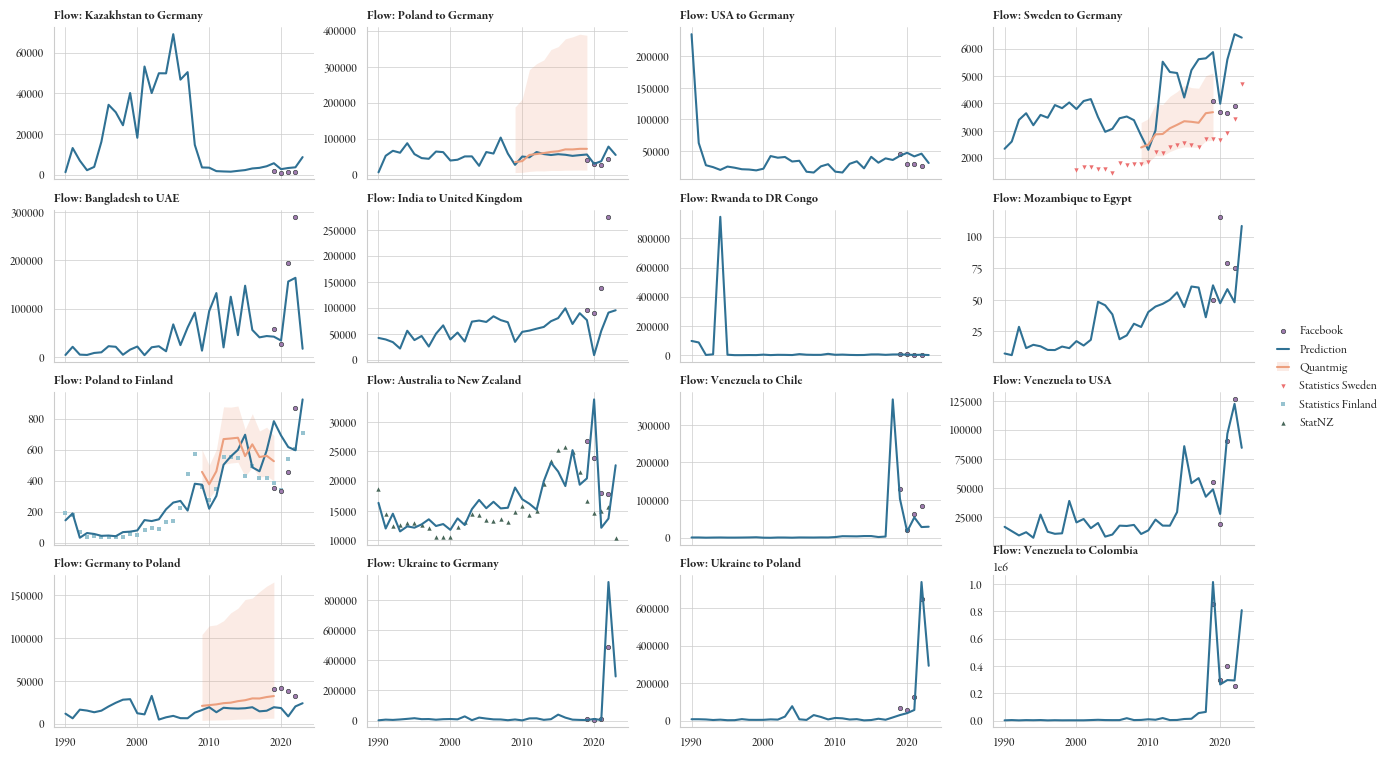

In [971]:
# Compare some flows
fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(12, 7))

# Track handles and labels for the figure legend
handles = {}
for idx, (o, d) in enumerate([("KAZ", "DEU"), ("POL", "DEU"), ("USA", "DEU"), ("SWE", "DEU"), ("BGD", "ARE"), ("IND", "GBR"), ("RWA", "COD"), ("MOZ", "EGY"), ("POL", "FIN"), ("AUS", "NZL"), ("VEN", "CHL"), ("VEN", "USA"), ("DEU", "POL"), ("UKR", "DEU"), ("UKR", "POL"), ("VEN", "COL")]):
    l = predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}, drop=True).plot(ax=axs.flatten()[idx])

    handles.update(putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    handles['Prediction'] = l[0]

# Add a legend
fig.legend(list(handles.values()), list(handles.keys()), bbox_to_anchor=(1.01, 0.5), loc='center left')

Let's plot some example stocks. The raw estimates are all conditioned on the first datapoint in the time series, that is the DESA estimate for 1990. However, this value might be erroneous. In order to improve the stock estimates, we can add a constant offset to each to better fit the time series. If we correct of demographic accounting (i.e. the death of the constant offset), this leaves the flow estimates unaffected. We calculate the offset by weighting the error between the prediction and DESA estimate with the weights from training, which reflect the error on the

In [972]:
# Calculate the fraction of population alive at start of 1990 in each destination country still alive at start of year
gamma = (1-death_rate.sel({"Year": range(1989, 2024)})).assign_coords({"Year": np.arange(1990, 2025, 1)}).rename({"Country ISO": "Destination ISO"})
gamma.loc[{"Year": 1990}] = 1.0
gamma = gamma.cumprod('Year')

# Calculate the stock offsets
stock_offset = utils.get_stock_offsets(
    stock_predictions=predictions['S_pred'].sel({"Year": stock_data.coords['Year']}),
    stock_data=stock_data['Start of year estimate'],
    weights=stock_data['Weight'].fillna(0),
    gamma=gamma
)

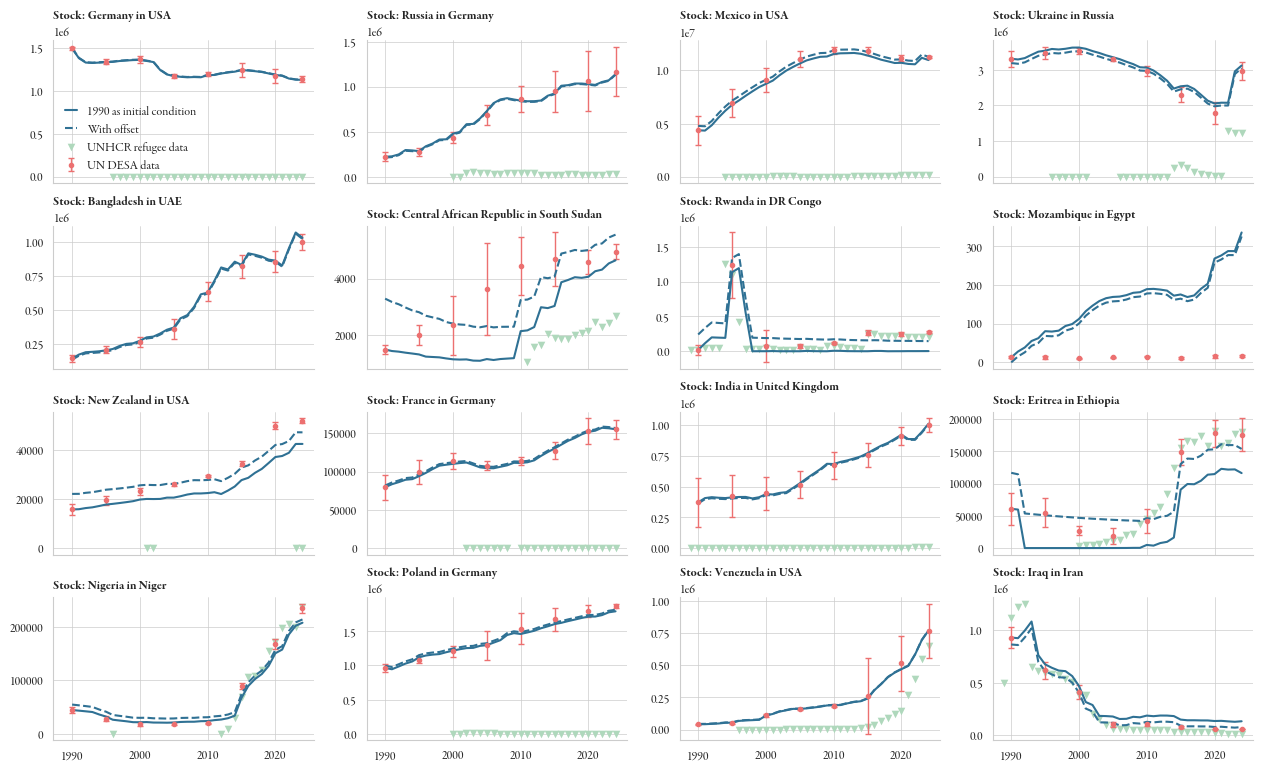

In [973]:
# Compare some stocks and compare with refugee data.
fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(12, 7), gridspec_kw={'hspace': 0.3})

for idx, (o, d) in enumerate([("DEU", "USA"), ("RUS", "DEU"), ("MEX", "USA"), ("UKR", "RUS"), ("BGD", "ARE"), ("CAF", "SSD"), ("RWA", "COD"), ("MOZ", "EGY"), ("NZL", "USA"), ("FRA", "DEU"), ("IND", "GBR"), ("ERI", "ETH"), ("NGA", "NER"), ("POL", "DEU"), ("VEN", "USA"), ("IRQ", "IRN")]):

    # Plot the UN DESA stocks (scaled to the start of the year) as well as the error
    stock = stock_data.sel({"Origin ISO": o, "Destination ISO": d})
    axs.flatten()[idx].errorbar(
        stock.coords['Year'], stock['Start of year estimate'], stock['Error'], lw=0, color='C1', elinewidth=1, markersize=3, capsize=2, marker='o', label='UN DESA data' if idx == 0 else None
    )

    # Plot the neural estimates
    predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}).plot(
        ax=axs.flatten()[idx], label='1990 as initial condition')

    # Plot the neural estimates with the offset
    (predictions['S_pred'] + stock_offset).sel({"Origin ISO": o, "Destination ISO": d}).plot(
        ax=axs.flatten()[idx], ls='dashed', c='C0', label='With offset')

    # Plot the stock of refugees
    refugees.sel({"Origin ISO": o, "Destination ISO": d}, drop=True).where(lambda x: x>0).plot.scatter(
        ax=axs.flatten()[idx], label='UNHCR refugee data', s=30, lw=0, c=colors['c_lightgreen'], marker='v')

    # Descriptive title
    axs.flatten()[idx].set_title(f"Stock: {putils.iso_to_name(o)} in {putils.iso_to_name(d)}", x=0, ha='left', weight='bold')
    axs.flatten()[idx].set(xlabel=None, ylabel=None)
axs[0, 0].legend()

Let's also look at the net migration predictions.

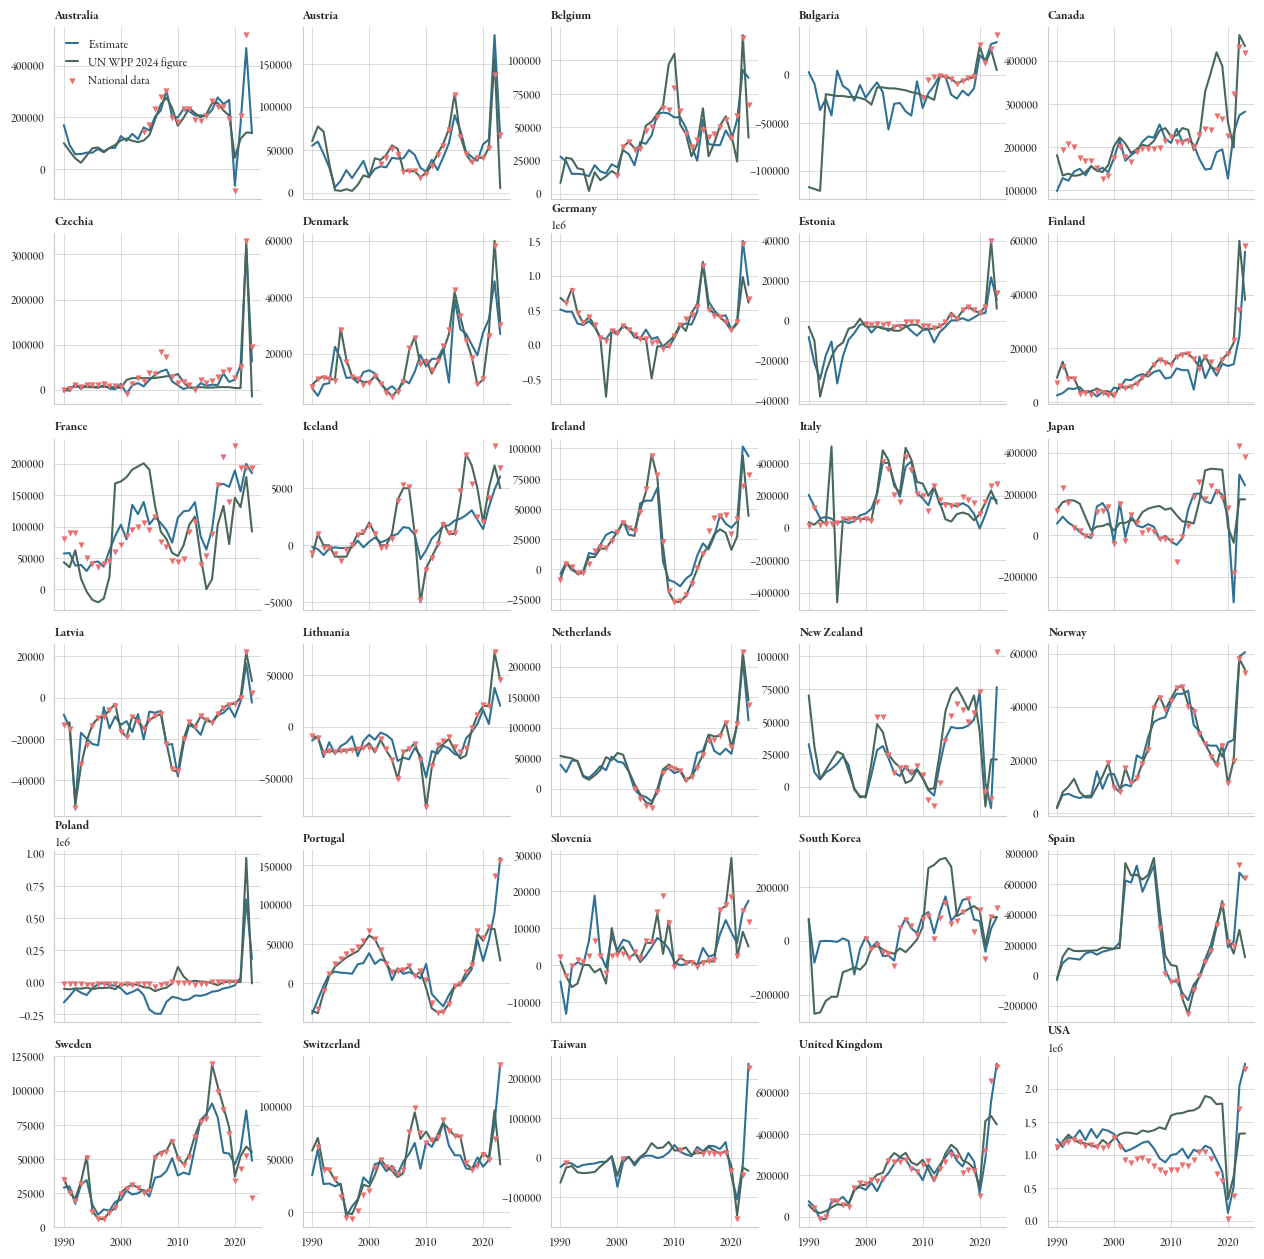

In [974]:
# Compare some net migration estimates
fig, axs = plt.subplots(nrows=6, ncols=5, sharex=True, sharey=False, figsize=(12, 12))
for idx, c in enumerate(NatStat_net_migration.coords['Country ISO']):

    predictions['mu_pred'].sel({"Country ISO": c}, drop=True).plot(ax=axs.flatten()[idx], label='Estimate')
    WPP_net_migration.sel({"Country ISO": c, "Year": range(1990, 2024)}, drop=True).plot(ax=axs.flatten()[idx], c='C2', label='UN WPP 2024 figure')
    NatStat_net_migration.sel({"Country ISO": c, "Year": range(1990, 2024)}, drop=True).plot.scatter(ax=axs.flatten()[idx], lw=0, marker='v', s=20, c='C1', label='National data', zorder=2)
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(c)}', x=0, ha='left', weight='bold')
    axs.flatten()[idx].set(xlabel=None, ylabel=None)

axs[0, 0].legend()

## Example: uncertainty quantification by sampling inputs
There are two sources of uncertainty: the uncertainty on the inputs and the degree to which the problem is ill-posed. The second source we estimate by training an ensemble of networks. Their output has been saved in the `Estimates` folder. To estimate the effect of uncertainty on the inputs on the predictions, we could sample the untransformed inputs, transform, and insert into the model. Sampling needs to occur before transforming because $\psi(\lambda x) \neq \lambda \psi(x)$.

Here we illustrate the principle, by using a standard deviation of 5% on all covariates except the stock data, where we use 10%. Binary covariates are not sampled.

In [975]:
# Transformation parameters, as well as a sampling std for each covariate
transformation_parameters = dict((k, {'transformation_parameters': data["transformation_parameters"][k], 'sample_std': 0.05}) for k in data["transformation_parameters"].keys())
transformation_parameters.update(**{"Linguistic_similarity": {'sample_std': 0.05}, "Religious_similarity": {'sample_std': 0.05}})

In [976]:
# Build some samples.
samples = utils.generate_samples(data, predictions, n_samples=5, cfg=cfg, transformation_parameters=transformation_parameters, stock_std=0.1, device=device, show_pbar=True)

# Add an offset to the mean
samples['S_sample']['mean'] += utils.get_stock_offsets(
    stock_predictions=samples['S_sample']['mean'].sel({"Year": stock_data.coords['Year']}),
    stock_data=stock_data['Start of year estimate'],
    weights=stock_data['Weight'].fillna(0),
    gamma=gamma
)

  0%|          | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

Let us take a look at how this affects the flow estimates:

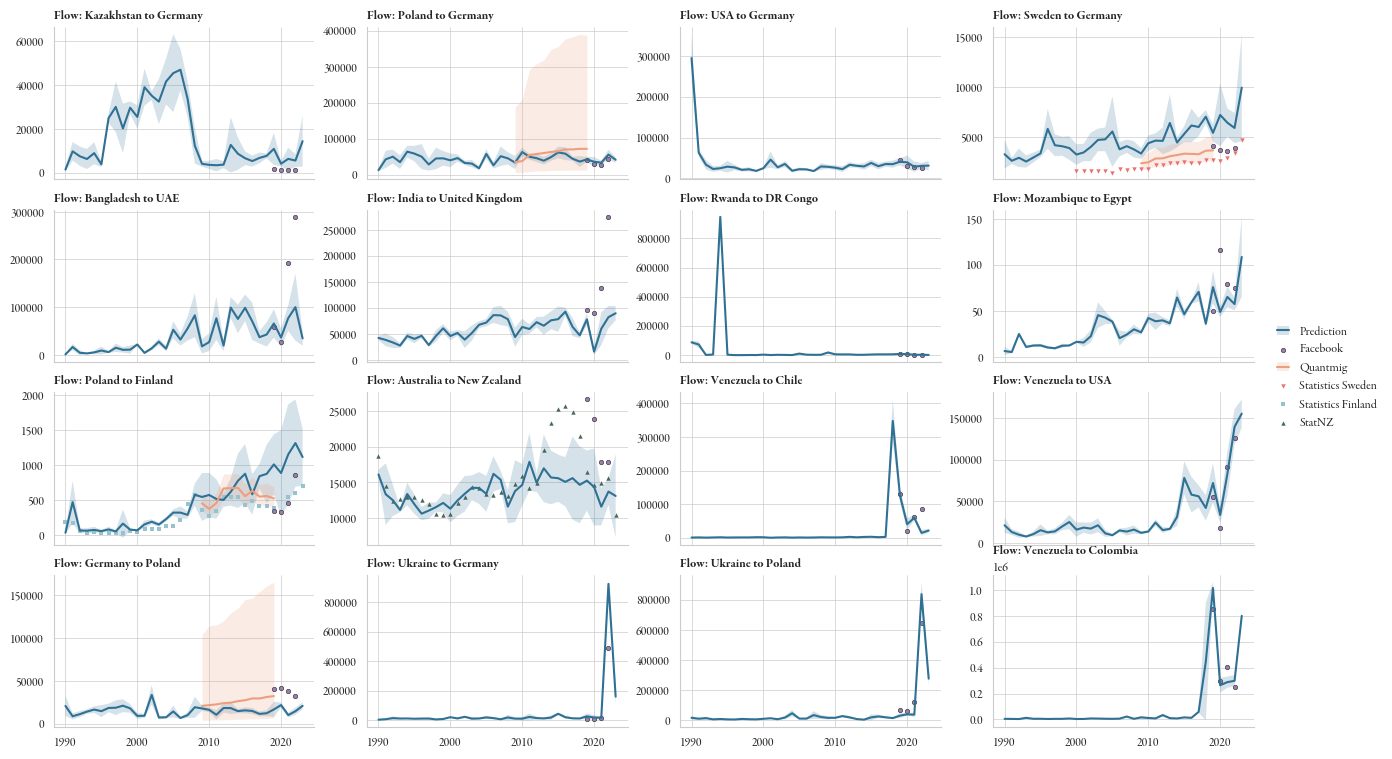

In [12]:
# Compare some flows
fig, axs = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False, figsize=(12, 7))

# Track handles and labels for the figure legend
handles = {}
for idx, (o, d) in enumerate([("KAZ", "DEU"), ("POL", "DEU"), ("USA", "DEU"), ("SWE", "DEU"), ("BGD", "ARE"), ("IND", "GBR"), ("RWA", "COD"), ("MOZ", "EGY"), ("POL", "FIN"), ("AUS", "NZL"), ("VEN", "CHL"), ("VEN", "USA"), ("DEU", "POL"), ("UKR", "DEU"), ("UKR", "POL"), ("VEN", "COL")]):

    _h1 = putils.errorband(samples['F_sample'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Prediction'] = _h1
    handles.update(putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))

# Add a legend
fig.legend(list(handles.values()), list(handles.keys()), bbox_to_anchor=(1.01, 0.5), loc='center left')

# Model sensitivity
The goal of the elasticity analysis is to gauge how sensitive the model predictions are to *relative* changes in each input covariate $x_i$, assuming the other covariates are held constant. To do this, we calculate the derivative $$\left\vert \dfrac{x_i}{{T}} \dfrac{\partial {T}}{\partial {x_i}}\right\vert = \left\vert \dfrac{\partial \log {T}}{\partial{x_i}}\right\vert \vert x_i \vert  = \left\vert \dfrac{\partial u_\theta}{\partial {x_i}} \right\vert \vert x_i\vert.$$ Since we are again interested in the sensitivity on the untransformed input variables, we use the chain rule: let $\chi_i$ = $\psi_\lambda(x_i)$; then $$\left\vert \dfrac{\partial u_\theta}{\partial {x_i}} \right\vert= \left\vert \dfrac{\partial u_\theta}{\partial {\chi_i}} \dfrac{\partial \psi}{\partial {x_i}}\right\vert$$ Using the fact that $\psi(-x) = -\psi(x)$, it is sufficient to calculate the last derivative on the absolute value of $x$.


In [977]:
# Matrix of elasticity samples, and associated covariate labels
elasticities, labels = utils.get_elasticities(data, predictions, cfg, n_edges=100000, n_years=5, device=device)
elasticities = abs(elasticities).cpu()

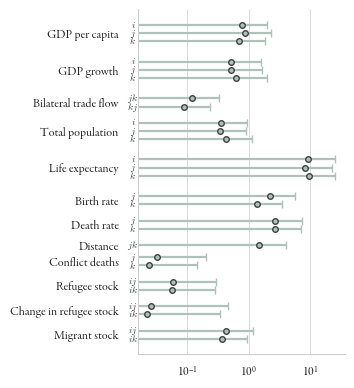

In [1246]:
fig, ax = plt.subplots(figsize=(page_width/2, page_width/2))

# Group titles for publication plot
group_titles = {
    'GDP cap': 'GDP per capita',
    'Population': 'Total population',
    'Refugees': 'Refugee stock',
    'Refugees diff': 'Change in refugee stock',
    'Stock': 'Migrant stock',
    'Trade': 'Bilateral trade flow'
}

# Sort the elasticities into groups
elasticity_dict = {}
for idx in range(elasticities.shape[1]):
    group = (labels[idx].split('$')[0])
    if group not in elasticity_dict.keys():
        elasticity_dict[group] = {}
    subgroup = labels[idx].split('{')[-1].replace('}$', '')
    elasticity_dict[group][subgroup] = torch.mean(elasticities[:, idx]), torch.std(elasticities[:, idx])

# Plot the elasticities in their groups
y0 = len(elasticity_dict.keys())
yticks_pos = []
yticks_labels = []
group_y = []
group_labels = []
for i, (group, val) in enumerate(elasticity_dict.items()):
    group_y.append(y0 -len(val)/2 * 0.3)
    group_labels.append(group_titles.get(group, group))
    for j, subgroup in enumerate(val.keys()):
        ax.errorbar(x=val[subgroup][0], xerr=val[subgroup][1], y=y0-j*0.3, markersize=4, lw=1.6, marker='o', markeredgecolor=colors['c_darkgrey'], markeredgewidth=1, capsize=3, capthick=2, c=colors['c_lightgrey'])
        yticks_pos.append(y0-j*0.3)
        yticks_labels.append(f'${subgroup}$')
    y0-=len(val)*1.5*0.3
ax.set_xscale('log')
ax.set_yticks(yticks_pos, yticks_labels, fontsize=7, color=colors['c_darkgrey'], ha='center', va='center')
ax.tick_params(axis='y', which='major', pad=0)
for idx in range(len(group_y)):
    ax.text(ax.get_xlim()[0]-0.008, group_y[idx], group_labels[idx], ha='right')
fig.subplots_adjust(left=0.4)
ax.grid(axis='y')

fig.savefig("Images/elasticities.pdf")

# Evaluation of the full model

Now let us evaluate the predictions made by the family of trained neural networks. The estimates are also located in the `Estimates` folder.

In [979]:
# Delete the previous estimates to free up some memory
del samples
del predictions

NameError: name 'samples' is not defined

In [4]:
# Load the predictions
predictions = dict(
    T_pred = xr.open_dataset("Estimates/T.nc"),
    F_pred = xr.open_dataset("Estimates/flows.nc"),
    mu_pred = xr.open_dataset("Estimates/net_migration.nc"),
    S_pred = xr.open_dataset("Estimates/stocks.nc")
)

Let's again look at some stocks, flows, and net migration estimates.

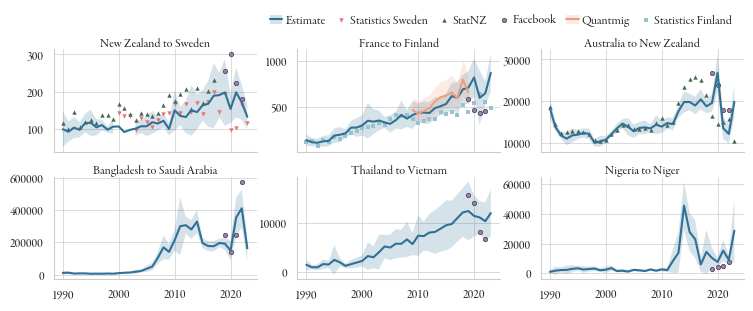

In [981]:
# Plot an example pane
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("NZL", "SWE"), ("FRA", "FIN"), ("AUS", "NZL"), ("BGD", "SAU"), ("THA", "VNM"), ("NGA", "NER")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)

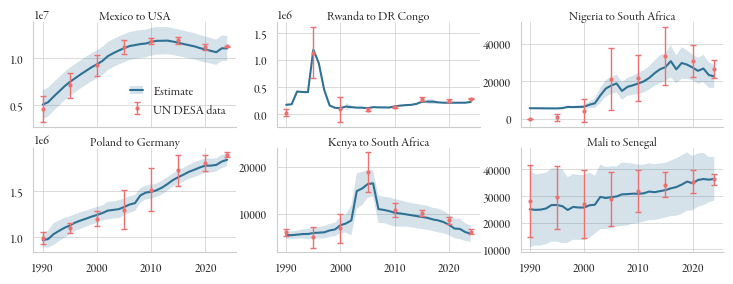

In [982]:
# Comparison of stocks
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True)

for idx, (o, d) in enumerate([("MEX", "USA"), ("RWA", "COD"), ("NGA", "ZAF"), ("POL", "DEU"), ("KEN", "ZAF"), ("MLI", "SEN")]):
    _h1 = putils.errorband(predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    _h2 = putils.errorbar(stock_data.sel({"Origin ISO": o, "Destination ISO": d}, drop=True), axs.flatten()[idx], y='2025 Revision', yerr='Error', lw=0, elinewidth=1, capsize=2, markersize=2, marker='o', zorder=2)
    axs.flatten()[idx].set(xlabel=None, ylabel=None)
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', y=0.95)
axs[0, 0].legend(handles=[_h1, _h2], labels=['Estimate', 'UN DESA data'])

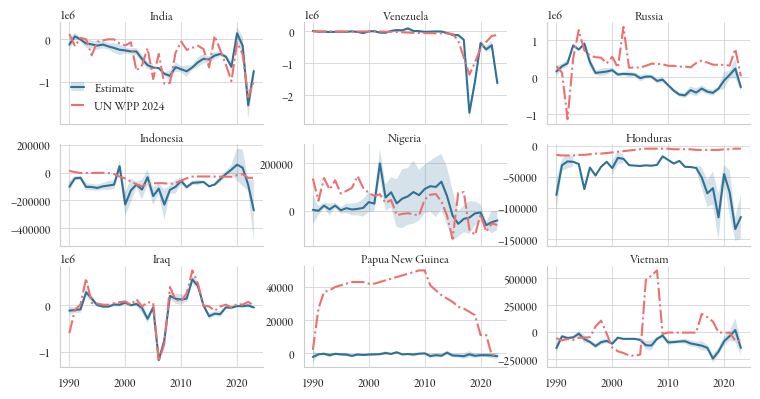

In [1776]:
# Comparison of net migration
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(page_width, page_width/2), sharex=True)
for idx, c in enumerate(['IND', 'VEN', 'RUS', 'IDN', 'NGA', 'HND', 'IRQ', 'PNG', 'VNM']):
    _h1 = putils.errorband(predictions['mu_pred'].sel({"Country ISO": c}), axs.flatten()[idx])
    _h2 = WPP_net_migration.sel({"Country ISO": c, "Year": range(1990, 2024)}).plot(ax=axs.flatten()[idx], ls='-.')
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(c)}', y=0.95)
    axs.flatten()[idx].set(xlabel=None, ylabel=   None)
axs[0, 0].legend(handles=[_h1, _h2[0]], labels=['Estimate', 'UN WPP 2024'])

fig.savefig("Images/net_migration_examples.pdf")

Let us take a look at the total flow volume over time

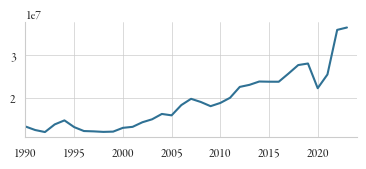

In [481]:
fig, ax = plt.subplots(figsize=(0.48*page_width, page_width/6))
predictions['F_pred']['mean'].sum(["Origin ISO", "Destination ISO"]).plot(ax=ax)
ax.set(xlabel=None, ylabel=None, xlim=(1990, 2024))
# fig.savefig("Images/total_flows.pdf", bbox_inches='tight', transparent=True)

We can look at total in- and outflows for each region, as well as the nets. We can also look at the total intra-regional flows

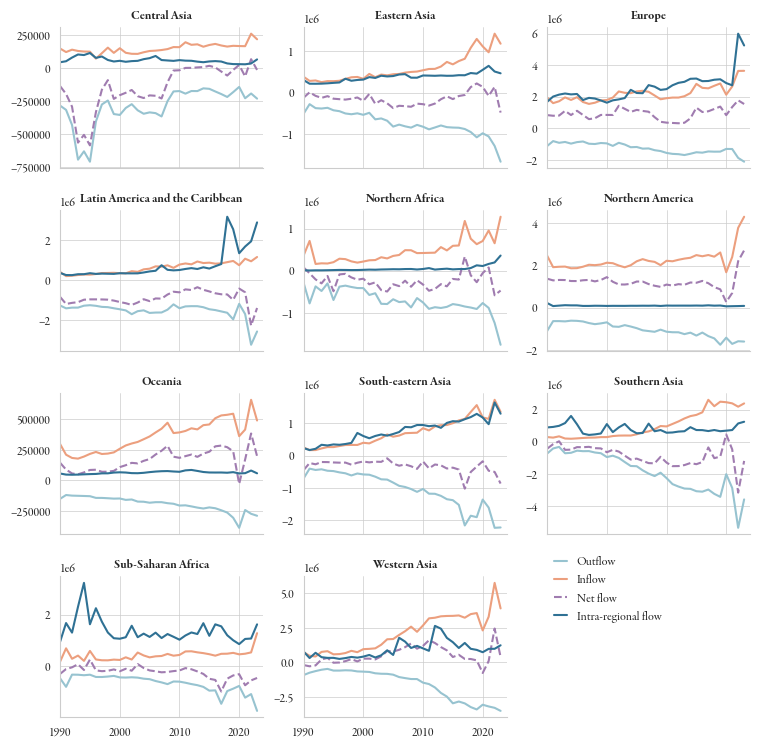

In [984]:
fig, axs = plt.subplots(ncols=3, nrows=4, sharex=True, sharey=False, figsize=(page_width, page_width), gridspec_kw={'hspace': 0.3})

for idx, region in enumerate(countries_by_region.keys()):
    out_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": np.concat([countries_by_region[k] for k in countries_by_region.keys() if k != region])}).sum(['Origin ISO', 'Destination ISO'])
    in_flow = predictions['F_pred']['mean'].sel({"Destination ISO": countries_by_region[region], "Origin ISO": np.concat([countries_by_region[k] for k in countries_by_region.keys() if k != region])}).sum(['Origin ISO', 'Destination ISO'])
    (-1*out_flow).plot(ax=axs.flatten()[idx], label='Outflow' if idx == 0 else None, c=colors['c_lightblue'])
    in_flow.plot(ax=axs.flatten()[idx], label='Inflow' if idx == 0 else None, c=colors['c_orange'])
    (in_flow - out_flow).plot(ax=axs.flatten()[idx], label='Net flow' if idx == 0 else None, c=colors['c_purple'], ls='dashed')

    intra_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": countries_by_region[region]}).sum(['Origin ISO', 'Destination ISO'])
    intra_flow.plot(ax=axs.flatten()[idx], label='Intra-regional flow' if idx == 0 else None,)

    axs.flatten()[idx].set_title(region, x=.50, weight='bold', ha='center')
    axs.flatten()[idx].set(xlabel=None, ylabel=None, xlim=(1990, 2024))
axs[-1, -1].axis('off')
fig.legend(bbox_to_anchor=(0.7, 0.25), loc='upper left')

We can also look at the volume of flows within regions. Europe has the largest intra-regional flow.

[Text(0.5, 0, ''), Text(0, 0.5, '')]

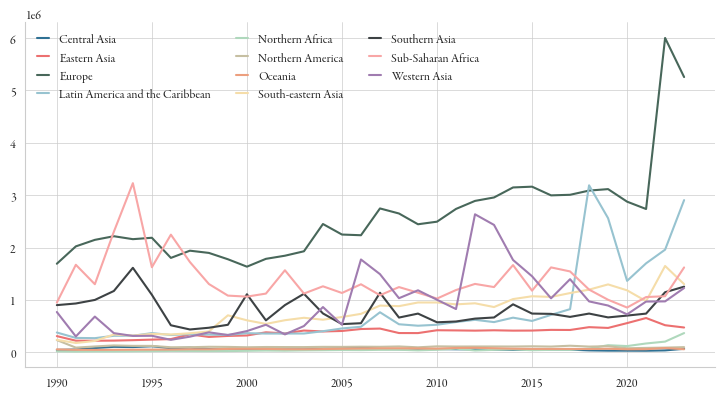

In [24]:
fig, ax = plt.subplots(figsize=(page_width, page_width/2))
for idx, region in enumerate(countries_by_region.keys()):
    intra_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": countries_by_region[region]}).sum(['Origin ISO', 'Destination ISO'])
    intra_flow.plot(ax=ax, label=region)
ax.legend(ncols=3)
ax.set(xlabel=None, ylabel=None)

# Performance evaluation
## Comparison with other methods
Let us look at how the model's predictions compare to the five-year flow estimates of other methods.

In [985]:
# Five-year flow estimates from other methods
five_year_flows = xr.load_dataset("Data/Flow_data/five_year_flows.nc")

# Five-year net migration estimates from the WPP
mu_5y_WPP = utils.aggregate(
    xr.load_dataset("Data/UN_WPP_data/UN_WPP_data.nc")['Net Number of Migrants (thousands)'].sel({"Year": range(1990, 2024)}) * 1000, np.arange(1990, 2021, 5)
)

# Five-year net migration estimates from other sources
mu_5y = xr.open_dataarray("Data/Flow_data/five_year_net_migration.nc")

In [986]:
# Calculate the five-year flows
five_year_flows_neural = utils.aggregate_T(predictions['T_pred']['mean'], np.arange(1990, 2021, 5))

In [987]:
# Calculate the evaluation metrics for the comparison methods and each neural network instance
stats = putils.comparison_stats(five_year_flows.sel({"Collection": ['Demig C2C', 'Eurostat', 'UN DESA IMFSC', 'ILO ASEAN'], "Coverage": "total"}), population)
neural_stats = putils.comparison_stats(
    putils.align_five_year_flows(five_year_flows, five_year_flows_neural).assign_coords({"Method": ['Neural']}).sel({"Collection": ['Demig C2C', 'Eurostat', 'UN DESA IMFSC', 'ILO ASEAN'], "Coverage": "total"}), population
)
stats = xr.concat([stats, neural_stats], dim='Method')
del neural_stats

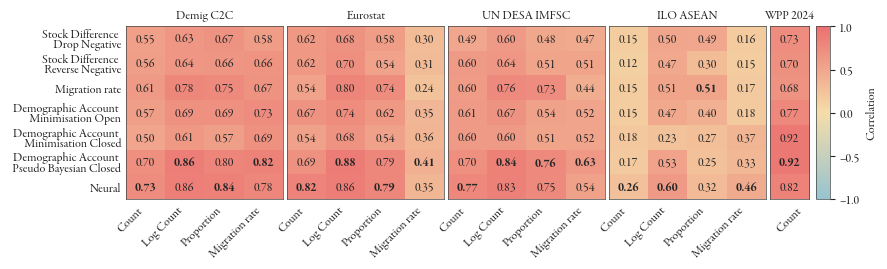

In [998]:
fig, axs = plt.subplots(ncols=5, sharex=False, sharey=True, gridspec_kw={'width_ratios': [4, 4, 4, 4, 1]}, figsize=(page_width, page_width/4))

# ColorManager for the heatmap
cm = ColorManager(cmap={'continuous': True, 'over': colors['c_purple'], 'from_values': {0: colors['c_lightblue'], 0.5: colors['c_yellow'], 1: colors['c_red']}}, vmin=-1, vmax=1)

# Plot the evaluation metrics
putils.plot_eval_metrics(stats, fig, axs, cm=cm)

# Plot the correlation on the UN WPP data
putils.plot_grid_to_ax(
    xr.concat([xr.corr(mu_5y, mu_5y_WPP, dim=['Country ISO', 'Year0']),
               xr.corr(
                   utils.aggregate(predictions['mu_pred']['mean'], mu_5y_WPP.coords['Year0'].data), mu_5y_WPP
               ).expand_dims({"Method": ['Neural']})], dim='Method').data.reshape(-1, 1), axs[-1], cm=cm)
axs[-1].set_xticks([0], ['Count'], ha='center', rotation=45)
axs[-1].set_title('WPP 2024')
for ax in axs:
    ax.tick_params('both', length=0)
# Format the tick labels
axs[0].set_yticklabels([fr"Neural: ${_t._text}$" if 'Z' in _t._text else _t._text for _t in axs[0].get_yticklabels()]);

fig.savefig("Images/performance_comparison.pdf")

These correlations are on the entire dataset, rather than along each individual flow corridor. Let us also look at the correlations over each edge (i.e. origin-destination pair). Additionally, we should check how well the uncertainties on our estimates math those on the Quantmig data and the UN stock estimates.

In [1254]:
import pandas as pd

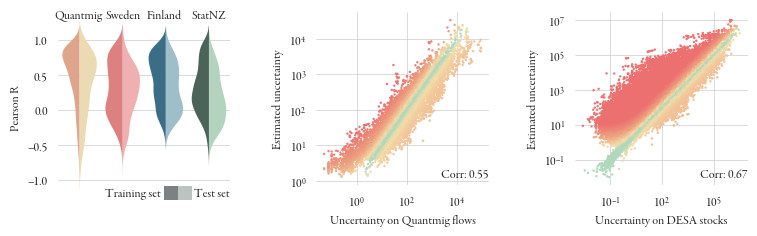

In [1371]:
fig, axs = plt.subplots(ncols=3, figsize=(page_width, page_width/4))

for label, item in flow_dsets.items():
    if label == 'Facebook':
        continue

    # Compute correlations
    ds = item['data']
    if 'central' in item.keys():
        ds = ds[item['central']]

    corr_train = xr.corr(ds.where(~mask), predictions['F_pred']['mean'].where(~mask), dim='Year').data.flatten()
    corr_test = xr.corr(ds.where(mask), test_flows['mean'].where(mask), dim='Year').data.flatten()

    # Build a DataFrame
    df = pd.DataFrame({
        'group': [label] * (len(corr_train) + len(corr_test)),
        'subgroup': ['Train'] * len(corr_train) + ['Test'] * len(corr_test),
        'value': np.concatenate([corr_train, corr_test])
    })

    # Plot
    kwargs = dict(split=True, fill=True, inner=None, gap=0., linewidth=0, legend=False)
    #kwargs.update(**plot_kwargs)
    sns.violinplot(df, x="group", y="value", hue="subgroup", ax=axs[0],
                   palette=dict(Train=item['primary_color'], Test=item['secondary_color']) if label!='Statistics Finland' else dict(Test=item['primary_color'], Train=item['secondary_color']), **kwargs)
axs[0].tick_params(axis='x', labelbottom=False)
axs[0].set(xlabel=None, ylabel=None)
axs[0].text(0.12, 0.97, 'Quantmig', transform=axs[0].transAxes, ha='center')
axs[0].text(0.38, 0.97, 'Sweden', transform=axs[0].transAxes, ha='center')
axs[0].text(0.62, 0.97, 'Finland', transform=axs[0].transAxes, ha='center')
axs[0].text(0.88, 0.97, 'StatNZ', transform=axs[0].transAxes, ha='center')

legend_box = fig.add_axes([0.15, -0.2, 0.1, 0.3])
legend_box.axis('off')
legend_box.set_xlim(0, 2)
legend_box.scatter([0.3], [1], s=100, marker='s', lw=0, color='#7C8182')
legend_box.scatter([0.7], [1], s=100, marker='s', lw=0,  color='#BBC4C1')
legend_box.text(0., 0.5, 'Training set', ha='right', va='center', transform=legend_box.transAxes)
legend_box.text(0.48, 0.5, 'Test set', ha='left', va='center', transform=legend_box.transAxes)

# for key in flow_dsets.keys():
#     if key == 'Facebook':
#         continue
#     y = flow_dsets[key]['data']
#     if 'central' in flow_dsets[key].keys():
#         y = y[flow_dsets[key]['central']]
#     sns.kdeplot(
#         xr.corr(
#             predictions['F_pred']['mean'].sel(**flow_dsets[key]['data'].coords),
#             y, dim='Year').data.flatten(), ax=axs[0], c=flow_dsets[key]['primary_color'], label=key, clip=[-1, 1]
#     )
# axs[0].legend()
axs[0].set(ylabel="Pearson R")
for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

x=0.25*(flow_dsets['Quantmig']['data']['flow_97.5%'] - flow_dsets['Quantmig']['data']['flow_2.5%'])
y=predictions['F_pred']['std'].sel(**flow_dsets['Quantmig']['data'].coords)
axs[1].text(1, 0.05, f"Corr: {xr.corr(x, y).item():>.2f}", transform=axs[1].transAxes, ha='right')

# ColorManager for the relative errors
cm = ColorManager(cmap={'continuous': True, 'over': colors['c_red'], 'under': colors['c_lightgreen'], 'from_values': {0: colors['c_lightgreen'], 0.33: colors['c_yellow'], 0.66: colors['c_orange'], 1: colors['c_red']}}, vmin=1e-1, vmax=10, norm='LogNorm')

putils.scatter_relative_errs(x, y, axs[1], cm=cm, s=0.5)
axs[1].set(yscale='log', xscale='log', xlabel='Uncertainty on Quantmig flows', ylabel='Estimated uncertainty')

x=stock_data['Error']
y=predictions['S_pred']['std'].sel(**stock_data.coords)
axs[2].text(1, 0.05, f"Corr: {xr.corr(x, y).item():>.2f}", transform=axs[2].transAxes, ha='right')

putils.scatter_relative_errs(x, y, axs[2], cm=cm, s=0.5)
axs[2].set(yscale='log', xscale='log', xlabel='Uncertainty on DESA stocks', ylabel='Estimated uncertainty')

fig.subplots_adjust(wspace=0.5)

# Shift the left axis down a little
pos = axs[0].get_position()  # Get current [left, bottom, width, height]
new_pos = [pos.x0, pos.y0 - 0.1, pos.width, pos.height*1.1]  # Shift downward
axs[0].set_position(new_pos)

fig.savefig("Images/performance_comparison_3.png")

## Compare with other net migration estimates
We plot the correlation over time of our net migration estimates against the UN WPP and USCB data.

100%|██████████| 242/242 [00:06<00:00, 39.01it/s]


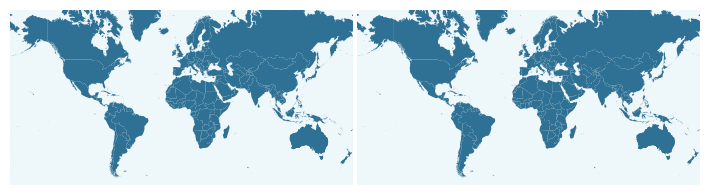

In [15]:
net_migration_USCB = xr.open_dataarray("Data/Net_migration/US_CB_net_migration.nc").sel({"Year": range(1990, 2024)})

world_figs, world_axs = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()), ncols=2, figsize=(page_width, page_width/2), gridspec_kw={'wspace': 0.01})
patches_double = []
for ax in world_axs:
    putils.add_map(ax, add_sea=True)
    patches_double.append(putils.add_country_patches(world, ax))

In [6]:
def rel_err(x, y):
    return abs(x-y)/x.where(lambda _x: _x>0, 1.0)

In [32]:
# Plot the correlation
cm1 = ColorManager(cmap={'continuous': True, 'bad': colors['c_lightgrey'], 'from_values': {0: colors['c_red'], 0.25: colors['c_orange'], 0.5: colors['c_yellow'], 0.75: colors['c_lightgreen'], 1: colors['c_darkgreen']}}, vmin=-1, vmax=1, norm=dict(name='BoundaryNorm', ncolors=256, boundaries=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]))
putils.plot_to_map(xr.corr(WPP_net_migration, predictions['mu_pred']['mean'], dim='Year'), world_figs, patches_double[0], cm=cm1, cbar_loc=[0.02, 0.28, 0.01, 0.2])

# Plot the relative error
cm2 = ColorManager(
    norm=dict(name='BoundaryNorm', ncolors=6, boundaries=[0, 10, 33, 66, 100, 200, 400]), vmin=0, vmax=200, cmap={'continuous': False, 'over': colors['c_purple'], 'from_values': {0: colors['c_darkgreen'], 0.25: colors['c_lightgreen'], 0.5: colors['c_yellow'], 0.75: colors['c_orange'], 0.8: colors['c_red'], 1: colors['c_purple']}}
)
putils.plot_to_map(100*(abs(WPP_net_migration - predictions['mu_pred']['mean'])/abs(WPP_net_migration)).median('Year'), world_figs, patches_double[1], norm='LogNorm', cm=cm2, add_cbar=False)

cbar1 = putils.add_cbar_to_map(world_figs, cm1, cbar_loc=[0.015, 0.27, 0.01, 0.3])
cbar1.set_label('Correlation')

cbar2 = putils.add_cbar_to_map(world_figs, cm2, cbar_loc=[0.52, 0.27, 0.01, 0.2], extend='max')
cbar2.set_label('MRE (%)')

# putils.add_cbar_to_map(fig, cm2, cbar_loc=[0.5, 0.25, 0.01, 0.2])
world_figs
world_figs.savefig("Images/net_migration_err.pdf", pad_inches=0)

## Performance on test edges
We can look at how well the neural networks have fared on the test data.

In [995]:
mask = xr.DataArray(torch.load("Results/z_100_yj_05_eta_10/FlowTestMask.pt", weights_only=True),
                    dims=['Year', 'Origin ISO', 'Destination ISO'], coords=predictions['F_pred'].coords)
test_flows = xr.open_dataset("Estimates/test_flows.nc")

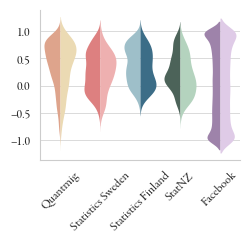

In [30]:
fig, ax = plt.subplots(figsize=(2, 1.5))
putils.correlation_violin(ax, pred=test_flows['mean'], mask=mask, items=flow_dsets)
ax.tick_params(axis='x', labelrotation=45)

Let us also visualise some flow predictions on the test set. Below is the list of all the corridors contained in the test set.

In [31]:
print(
    mask.any(dim='Year').stack(edge=['Origin ISO', 'Destination ISO']).where(lambda x: x).dropna('edge').coords['edge'].data.tolist()
)

[('ABW', 'NZL'), ('AFG', 'AZE'), ('AFG', 'BGR'), ('AFG', 'BIH'), ('AFG', 'BRN'), ('AFG', 'BWA'), ('AFG', 'CAN'), ('AFG', 'CIV'), ('AFG', 'COL'), ('AFG', 'CPV'), ('AFG', 'DNK'), ('AFG', 'EGY'), ('AFG', 'GEO'), ('AFG', 'GMB'), ('AFG', 'GNQ'), ('AFG', 'HUN'), ('AFG', 'KWT'), ('AFG', 'LVA'), ('AFG', 'MDV'), ('AFG', 'MKD'), ('AFG', 'NPL'), ('AFG', 'PHL'), ('AFG', 'ROU'), ('AFG', 'SDN'), ('AFG', 'TON'), ('AFG', 'TWN'), ('AFG', 'TZA'), ('AFG', 'VCT'), ('AFG', 'ZMB'), ('AGO', 'BDI'), ('AGO', 'BHR'), ('AGO', 'BRA'), ('AGO', 'CAF'), ('AGO', 'CHL'), ('AGO', 'DEU'), ('AGO', 'DJI'), ('AGO', 'ETH'), ('AGO', 'FSM'), ('AGO', 'GAB'), ('AGO', 'GEO'), ('AGO', 'GNB'), ('AGO', 'GRD'), ('AGO', 'GTM'), ('AGO', 'HND'), ('AGO', 'HTI'), ('AGO', 'IND'), ('AGO', 'IRL'), ('AGO', 'JOR'), ('AGO', 'KGZ'), ('AGO', 'LSO'), ('AGO', 'MDG'), ('AGO', 'MMR'), ('AGO', 'NER'), ('AGO', 'NZL'), ('AGO', 'OMN'), ('AGO', 'PHL'), ('AGO', 'ROU'), ('AGO', 'SEN'), ('AGO', 'STP'), ('AGO', 'SYR'), ('AGO', 'TLS'), ('AGO', 'TTO'), ('AGO',

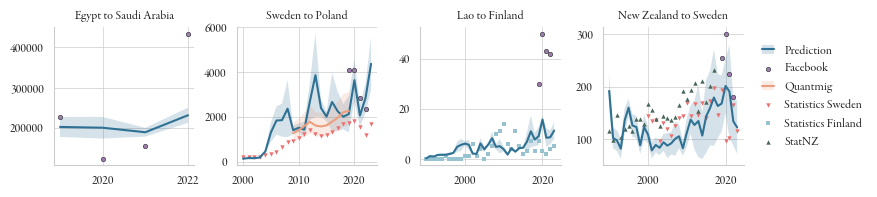

In [32]:
fig, axs = plt.subplots(ncols=4, figsize=(page_width, page_width/5), sharex=False, gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
handles = {}

for idx, (o, d) in enumerate([('EGY', 'SAU'), ('SWE', 'POL'), ('LAO', 'FIN'), ('NZL', 'SWE')]):

    # Plot the predictions
    yrs = flow_data.sel({"Origin ISO": o, "Destination ISO": d}).dropna('Year').coords['Year'].data
    l = putils.errorband(test_flows.sel({"Origin ISO": o, "Destination ISO": d, "Year": yrs}, drop=True), axs.flatten()[idx])
    handles['Prediction'] = l

    # Plot the data
    _h = putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d)
    handles.update(**_h)

    axs[idx].set_title(f"{putils.iso_to_name(o)} to {putils.iso_to_name(d)}", x=0.5)


fig.legend(list(handles.values()), list(handles.keys()), bbox_to_anchor=(1.01, 0.5), loc='center left')

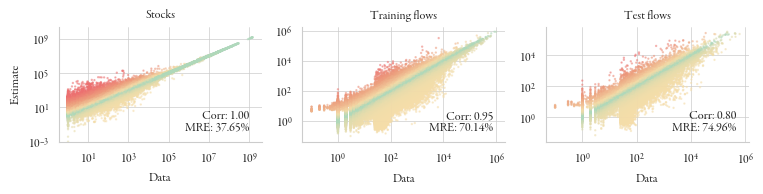

In [1359]:
fig, axs = plt.subplots(ncols=3, figsize=(page_width, page_width/6))

# ColorManager for the relative errors
cm = ColorManager(cmap={'continuous': True, 'over': colors['c_red'], 'under': colors['c_lightgreen'], 'from_values': {0: colors['c_lightgreen'], 0.33: colors['c_yellow'], 0.66: colors['c_orange'], 1: colors['c_red']}}, vmin=1e-1, vmax=100, norm='LogNorm')

# Compare relative errors
for idx, (x, y) in enumerate([
    (stock_data['Start of year estimate'], predictions['S_pred']['mean'].sel({"Year": stock_data.coords['Year'].data})),
    (flow_data, predictions['F_pred']['mean']),
    (flow_data.where(mask), test_flows['mean'].where(mask)),
]):

    putils.scatter_relative_errs(x, y, ax=axs[idx], cm=cm, s=0.5, alpha=0.5)
    axs[idx].set(xscale='log', yscale='log')
    # Correlation
    axs[idx].text(0.94, 0.2, f"Corr: {xr.corr(x, y):>.2f}", transform=axs[idx].transAxes, ha='right')
    # Median relative error
    axs[idx].text(0.94, 0.1, f"MRE: {100*np.nanmedian(abs(x-y)/x):>.2f}%", transform=axs[idx].transAxes, ha='right')

axs[0].set(ylim=(1e-3, None), title='Stocks', xlabel='Data', ylabel='Estimate')
axs[1].set(title='Training flows', xlabel='Data')
axs[2].set(title='Test flows', xlabel='Data')

fig.savefig("Images/performance_2.png")

# Plot flows to map
We can visualise flows on a map, and colour the flows by year.

In [33]:
def coordinate_to_proj(ax, lat, lon) -> tuple[float, float]:
    """ Projects a coordinate point (lat-lon) to the axis projection, in preparation for plotting. """
    return ax.projection.transform_point(lon, lat, src_crs=ccrs.PlateCarree())

def coordinate_to_figure_pos(fig, ax, lat, lon) -> tuple[float, float]:
    """ Converts a coordinate point (lat-lon) to a relative figure position"""
    return fig.transFigure.inverted().transform(ax.transData.transform(
        coordinate_to_proj(ax, lat, lon)
    ))

def is_point_in_extent(ax, lat, lon):
    """
    Checks if a lat-lon point is within the visible extent of the given axes.
    """
    extent = ax.get_extent(crs=ccrs.PlateCarree())  # [xmin, xmax, ymin, ymax] in the CRS
    lon_min, lon_max, lat_min, lat_max = extent

    # Handle crossing the dateline
    if lon_min > lon_max:
        in_lon = lon >= lon_min or lon <= lon_max
    else:
        in_lon = lon_min <= lon <= lon_max

    in_lat = lat_min <= lat <= lat_max

    return in_lon and in_lat

def highlight_countries(ax, patch_dict,
                        countries: str | list,
                        coordinates: dict = None,
                        patch_kwargs: dict = {}, text_kwargs: dict = {}):

    """ Marks countries on the map and adds a country label, if specified.

    :param ax: axis to use
    :param patch_dict: dictionary of patches
    :param countries: country or list of countries to highlight
    :param coordinates: dictionary of coordinates for the text labels (optional)
    """

    default_text_kwargs = dict(fontsize=7, color=colors['c_darkgrey'], alpha=0.5, ha='center', va='center')
    default_text_kwargs.update(**text_kwargs)
    default_patch_kwargs = dict(lw=0.7, ec='white', facecolor=colors['c_lightbrown'], zorder=2)
    default_patch_kwargs.update(**patch_kwargs)
    if isinstance(countries, str):
        countries = [countries]

    # Remove any previous texts
    for text in ax.texts:
        text.remove()

    # Highlight countries in list
    for c in countries:
        if c not in patch_dict.keys():
            continue
        if coordinates is not None and is_point_in_extent(ax, *coordinates[c]):
            ax.text(*coordinate_to_proj(ax, *coordinates[c]), putils.iso_to_name(c).title(), **default_text_kwargs)
        patch_dict[c].set(**default_patch_kwargs)

def add_borders(ax, **kwargs):
    """ Adds borders to an axis.

    :param ax: axis to use
    :param kwargs: kwargs, passed to ax.add_feature
    """
    default_kwargs = dict(linewidth=0.2, edgecolor=colors['c_darkgrey'], linestyle='-', alpha=0.8)
    default_kwargs.update(**kwargs)
    ax.add_feature(cartopy.feature.BORDERS, **default_kwargs)

def add_ocean(ax, **kwargs):
    """ Adds the ocean to an axis.

    :param ax: axis to use
    :param kwargs: kwargs, passed to ax.add_feature
    """
    default_kwargs = dict(linewidth=0., edgecolor=colors['c_lightblue'], alpha=0.2)
    default_kwargs.update(**kwargs)
    ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m'), **default_kwargs)

def add_gridlines(ax, **kwargs):
    """ Adds gridlines to an axis.

    :param ax: axis to use
    :param kwargs: kwargs, passed to ax.gridlines()
    """
    default_kwargs = dict(linewidth=0.2, color=colors['c_darkgrey'], linestyle='-', alpha=0.5, draw_labels=False, zorder=max([_.zorder for _ in ax.get_children()]))
    default_kwargs.update(**kwargs)
    ax.gridlines(crs=ccrs.PlateCarree(), **default_kwargs)


def point_in_axis(ax, lat, lon):
    """ Checks whether a point lies in a given axis."""
    return all([~np.isnan(c) for c in coordinate_to_proj(ax, lat, lon)])

def get_coord_ax(fig, coord):
    for ax in fig.axes:
        if point_in_axis(ax, *coord):
            return ax

def plot_arrow(fig, ax_idx: int = None, *, coord1, coord2, **kwargs):

    """ Plots an arrow from one point to another. If the figure is composed of two hemispheres,
    the function determines the hemispheres of each point."""

    def plot_arrow_to_ax(ax, *, posA: tuple[float, float], posB: tuple[float, float], **kwargs):
        """ Plots a FancyArrowPatch to an axis."""
        ax.add_artist(
            FancyArrowPatch(
                transform=ax.transData,
                posA=posA, posB=posB, zorder=max([_.zorder for _ in ax.get_children()]), **kwargs
        ))

    def plot_arrow_to_fig(fig, *, posA: tuple[float, float], posB: tuple[float, float], **kwargs):
        """ Plots a FancyArrowPatch to a figure"""
        fig.add_artist(
            FancyArrowPatch(
                transform=fig.transFigure,
                posA=posA, posB=posB, **kwargs
        ))

    # If axis was specified:
    if len(fig.axes) == 1 or ax_idx is not None:
        if ax_idx is None:
            ax_idx = 0
        if is_point_in_extent(fig.axes[ax_idx], *coord1) and is_point_in_extent(fig.axes[ax_idx], *coord2):
            plot_arrow_to_ax(fig.axes[ax_idx],
                            posA=coordinate_to_proj(fig.axes[ax_idx], *coord1),
                            posB=coordinate_to_proj(fig.axes[ax_idx], *coord2),
                            **kwargs)
    # Need to determine the axis of each point if multiple axes present
    else:
        posA = coordinate_to_figure_pos(fig, get_coord_ax(fig, coord1), *coord1)
        posB = coordinate_to_figure_pos(fig, get_coord_ax(fig, coord2), *coord2)
        plot_arrow_to_fig(fig, posA=posA, posB=posB, **kwargs)

def get_flow_items(T: xr.DataArray) -> list[dict]:
    """ Extracts a list of flow items that can be plotted to a map; items are sorted in descending order.

    :param T: flow table
    :return: list of flow items
    """
    stacked = T.stack({"idx": T.dims}).where(lambda x: x>0).dropna('idx')
    stacked = stacked.reset_index('idx').to_dataframe(name='Value').reset_index(drop=True).to_dict(orient='records')
    return sorted(stacked, key=lambda x: x['Value'], reverse=True)

def plot_flows(fig, *,
               ax_idx: int = None,
               flow_items, special_coords: dict = {},
               color_dict: dict = None,
               color_key: str = None,
               cm: ColorManager = None,
               mutation_scale: float = None,
               jiggle: float = None,
               scale: float = 1e-3,
               **kwargs):

    for item in flow_items:
        item_cfg = {'coord1': special_coords.get(item['Origin ISO'], coordinates[item['Origin ISO']]), 'coord2': special_coords.get(item['Destination ISO'], coordinates[item['Destination ISO']]), 'mutation_scale': scale * item['Value'] if mutation_scale is None else mutation_scale}
        if jiggle:
            coords = copy.deepcopy(coordinates)
            coords.update(**special_coords)
            item_cfg['coord1'] = get_random_coord_in_country(fig, item['Origin ISO'], coordinates=coords, jiggle=jiggle)
            item_cfg['coord2'] = get_random_coord_in_country(fig, item['Destination ISO'], coordinates=coords, jiggle=jiggle)
        if color_dict is not None:
            item_cfg['color'] = color_dict.get(item[color_key], 'C0')
        elif cm is not None:
            item_cfg['color'] = cm.map_to_color(item[color_key])
        plot_arrow(fig, ax_idx=ax_idx, **item_cfg, **kwargs)

def get_random_coord_in_country(fig, country, *, coordinates: dict, jiggle: float = 0.1, attempts=5):

    """Returns a random (lon, lat) point within a country's shape"""
    ax_idx = 0
    center_x, center_y = coordinate_to_proj(fig.axes[ax_idx], *coordinates[country])
    while np.isnan(center_x) or np.isnan(center_y):
        ax_idx += 1
        center_x, center_y = coordinate_to_proj(fig.axes[ax_idx], *coordinates[country])
    ax = fig.axes[ax_idx]
    if np.isnan(center_x) or np.isnan(center_y):
        return ccrs.PlateCarree().transform_point(center_x, center_y, src_crs=world.to_crs(ax.projection).crs)[::-1]

    # Get the country geometry
    geometry = (world[world['ISO_A3_EH'] == country]).to_crs(ax.projection)
    if geometry.bounds.empty:
        return coordinates[country]
    minx, miny, maxx, maxy = geometry.bounds.values.tolist()[0]

    # Catch infinities due to projection distortions
    if any([np.isinf(val) for val in geometry.bounds.values.tolist()[0]]):
        return coordinates[country]

    for _ in range(attempts):
        # Generate random point within bounding box
        random_point = Point(np.random.normal(center_x, jiggle*abs(maxx-minx)), np.random.normal(center_y, jiggle*abs(maxy-miny)))
        if all(geometry.contains(random_point)):
            return ccrs.PlateCarree().transform_point(random_point.x, random_point.y, src_crs=world.to_crs(ax.projection).crs)[::-1]
    return ccrs.PlateCarree().transform_point(center_x, center_y, src_crs=world.to_crs(ax.projection).crs)[::-1]


In [34]:
largest_flows = get_flow_items(predictions['F_pred']['mean'])

## Triple globe

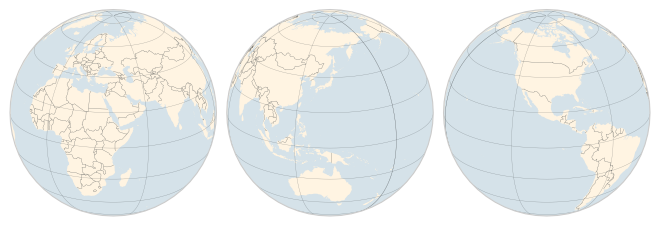

In [35]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.05)
axs = np.array([
    fig.add_subplot(131, projection=ccrs.Orthographic(central_longitude=40, central_latitude=20)),
    fig.add_subplot(132, projection=ccrs.Orthographic(central_longitude=140, central_latitude=20)),
    fig.add_subplot(133, projection=ccrs.Orthographic(central_longitude=-100, central_latitude=20))
    ])
# country_patches = [
#     putils.add_country_patches(world.to_crs(ax.projection), ax, color=None, alpha=0.4) for ax in axs
# ]
for ax in axs:
    ax.set(facecolor='#FFF4E2', alpha=1)
    add_borders(ax)
    add_ocean(ax, alpha=1, color='#D5E2E9')
    add_gridlines(ax)
    ax.set_global()
fig.patch.set_alpha(0)

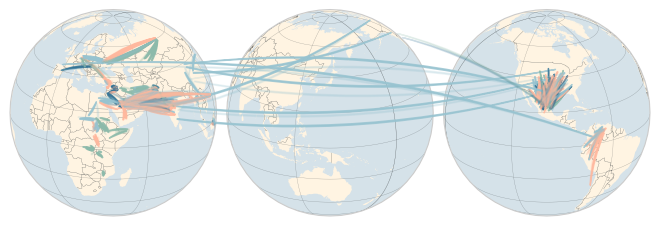

In [835]:
for flow in largest_flows[:250]:
    plot_arrow(fig,
               coord1=get_random_coord_in_country(fig, flow['Origin ISO'], coordinates=coordinates),
               coord2=get_random_coord_in_country(fig, flow['Destination ISO'], coordinates=coordinates),
               mutation_scale=10,
               connectionstyle='arc3,rad=0.1',
               arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
               alpha=0.2, #0.5*1e-6*flow['Value'],
               color=cm.map_to_color(flow['Year']),
               lw=1
               )
fig

## Double globe, dark colour scheme

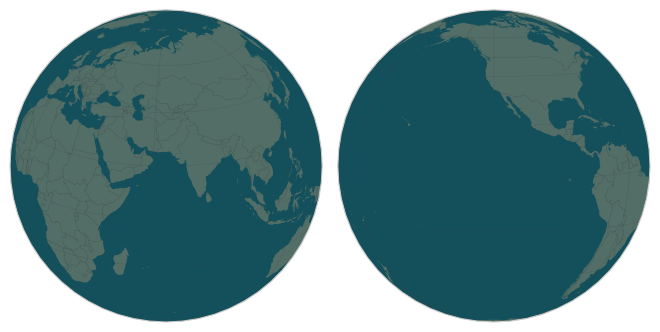

In [849]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.05)
axs = np.array([
    fig.add_subplot(121, projection=ccrs.Orthographic(central_longitude=65, central_latitude=20)),
    fig.add_subplot(122, projection=ccrs.Orthographic(central_longitude=-120, central_latitude=5))
    ])
for ax in axs:
    ax.set(facecolor='#536E66', alpha=1)
    add_borders(ax)
    add_ocean(ax, alpha=1, color='#13505B')
    add_gridlines(ax)
fig.patch.set_alpha(0)

# country_patches = [
#     putils.add_country_patches(world.to_crs(axs[0].projection), axs[0], color='#FFF4E2', alpha=0.4),
#     putils.add_country_patches(world.to_crs(axs[1].projection), axs[1], color='#FFF4E2', alpha=0.4)
# ]



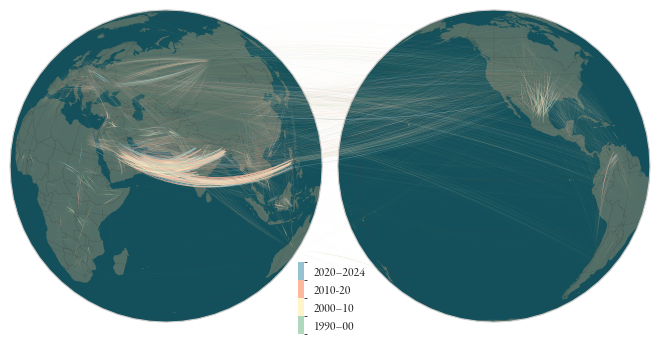

In [859]:
for ax in axs:
    for a in ax.collections[244:]: # do not remove patches
        a.remove()
    while len(ax.artists) > 1: # do not remove grid
        ax.artists[-1].remove()
    while len(ax.patches) > 0:
        ax.patches[-1].remove()
while len(fig.artists) > 0:
    fig.artists[-1].remove()
while len(fig.lines) > 0:
    fig.lines[-1].remove()

cm = ColorManager(cmap={'from_values': {1995: colors['c_lightgreen'], 2005: '#FFF4CA', 2015: '#FFB89E', 2025: colors['c_lightblue']}})

# items = {}
# for item in largest_flows[:1000]:
#     if (item['Origin ISO'], item['Destination ISO']) not in items.keys():
#         items[(item['Origin ISO'], item['Destination ISO'])] = [(item['Year'], item['Value'])]
#     else:
#         items[(item['Origin ISO'], item['Destination ISO'])].append((item['Year'], item['Value']))
# flow_items = []
# for k, v in items.items():
#     for idx in range(len(v)):
#         flow_items.append({'Origin ISO': k[0], 'Destination ISO': k[1], 'Year': v[idx][0],
#                            'Value': v[idx][1],
#                            'rad': (-1)**idx * 0.2 + 0.9*(-1)**idx * idx/len(v),
#                            'alpha': 0.7 if len(v) > 1 else 1})

for flow in largest_flows[:10000]:
    if not (flow['Origin ISO'] in ['IND', 'BGD', 'PHL'] and flow['Destination ISO'] in ['SAU', 'ARE']):
        plot_arrow(fig, coord1=get_random_coord_in_country(fig, flow['Origin ISO'], coordinates=coordinates, jiggle=0.1 if flow['Origin ISO'] != 'RUS' else 0.01),
                   coord2=get_random_coord_in_country(fig, flow['Destination ISO'], coordinates=coordinates, jiggle=0.1 if flow['Destination ISO'] != 'RUS' else 0.01),
                   mutation_scale=5*1e-6*flow['Value'],
                   connectionstyle='arc3,rad=0.1',
                   arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
                   alpha=0.8, #0.5*1e-6*flow['Value'],
                   color=cm.map_to_color(flow['Year']),
                   lw=0
                   )
    else:
        plot_arrow(fig, coord1=get_random_coord_in_country(fig, flow['Origin ISO'], coordinates=coordinates, jiggle=0.1 if flow['Origin ISO'] != 'RUS' else 0.01),
           coord2=get_random_coord_in_country(fig, flow['Destination ISO'], coordinates=coordinates, jiggle=0.1 if flow['Destination ISO'] != 'RUS' else 0.01),
           mutation_scale=5*1e-5*flow['Value'],
           connectionstyle='arc3,rad=-0.3',
           arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
           alpha=0.8, #min(0.9, 1*1e-6*flow['Value']),
           lw=0,
           color=cm.map_to_color(flow['Year'])
           )

for ax in fig.axes[2:]:
    ax.remove()
cbar_loc = [0.45, 0.15, 0.01, 0.15]
cax = fig.add_axes(cbar_loc)
from matplotlib.colorbar import Colorbar
cbar = Colorbar(
        cax, cmap=cm.cmap, orientation='vertical', location='right', drawedges=False, norm=cm.norm
    )
cbar.set_ticks([1995, 2005, 2015, 2025], labels=['1990–00', '2000–10', '2010-20', '2020–2024'])
cbar.outline.set_linewidth(0.2)
cbar.dividers.set_color('none')
cbar.outline.set_visible(False)  # Remove colorbar border
cax.tick_params(width=0.)
cbar.dividers.set_color('none')

fig

In [860]:
fig.savefig("Images/global_flows_2.png", transparent=False)

In [443]:
import copy
special_coordinates = copy.deepcopy(coordinates)

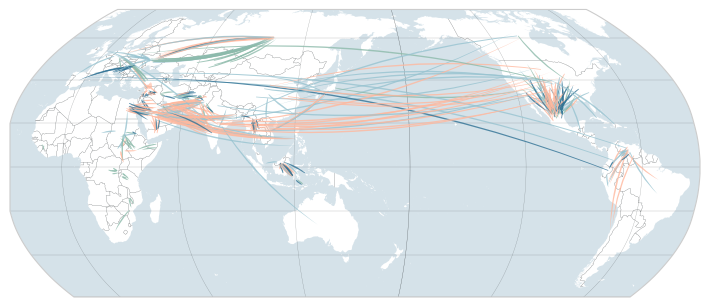

In [563]:
fig_2, ax_2 = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=150)), figsize=(page_width, page_width))
#patches_2 = putils.add_country_patches(world.to_crs(ax_2.projection), ax_2, color=colors['c_lightgrey'])

add_borders(ax_2)
add_ocean(ax_2)
add_gridlines(ax_2)
ax_2.set_extent([-30.0, -30.1, -60, 75])

for flow in largest_flows[:500]:
    if not (flow['Origin ISO'] in ['IND', 'BGD', 'PHL'] and flow['Destination ISO'] in ['SAU', 'ARE']):
        plot_arrow(fig_2, coord1=get_random_coord_in_country(fig, flow['Origin ISO'], coordinates=coordinates, jiggle=0.1 if flow['Origin ISO'] != 'RUS' else 0.01),
                   coord2=get_random_coord_in_country(fig, flow['Destination ISO'], coordinates=coordinates, jiggle=0.1 if flow['Destination ISO'] != 'RUS' else 0.01),
                   mutation_scale=10, #5*1e-6*flow['Value'],
                   connectionstyle='arc3,rad=0.1',
                   arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
                   alpha=0.8, #0.5*1e-6*flow['Value'],
                   color=cm.map_to_color(flow['Year']),
                   lw=0
                   )
#
#
# highlight_countries(ax_2, patches_2, 'RUS')
# for a in ax_2.collections[244:]:
#     a.remove()
# while len(ax_2.artists) > 0:
#     ax_2.artists[-1].remove()
# while len(ax_2.patches) > 0:
#     ax_2.patches[-1].remove()
#
# ax_2.scatter(
#     *ax_2.projection.transform_point(*coordinates['IND'][::-1], src_crs=ccrs.PlateCarree())
# )
#
# ax_2.scatter(
#     *ax_2.projection.transform_point(*coordinates['BRA'][::-1], src_crs=ccrs.PlateCarree())
# )
#
# plot_arrow(fig_2, coord1=coordinates['ZAF'], coord2=coordinates['AUS'], mutation_scale=20,
#            connectionstyle='arc3,rad=0.1', arrowstyle=f'simple')

## Eastern Europe, 1991

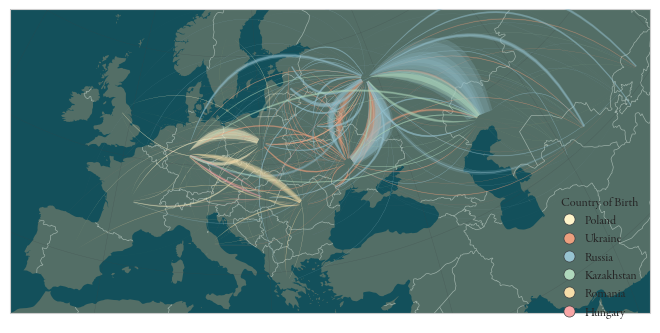

In [1715]:
fig_3 = plt.figure()
ax_3 = fig_3.add_subplot(111, projection=ccrs.Orthographic(central_latitude=55, central_longitude=15))
ax_3.set(facecolor='#536E66', alpha=1)
add_borders(ax_3, edgecolor=colors['c_lightgrey'], linewidth=0.5)
add_ocean(ax_3, color='#13505B', alpha=1)
add_gridlines(ax_3)
ax_3.set_extent([-10, 70, 35, 52], crs=ccrs.PlateCarree())

# highlight_countries(ax_3, country_patches_3, countries=['POL', 'DEU', 'UKR'], coordinates=coordinates, patch_kwargs=dict(facecolor=colors['c_lightgrey']))

handles, labels = [], []
for birth_iso, rad in [('POL', 0.4), ('UKR', 0.4), ('RUS', 0.6), ('KAZ', 0.3), ('ROU', 0.2), ('HUN', -0.1)]:

    plot_flows(fig_3,
               flow_items=get_flow_items(predictions['T_pred']['mean'].sel({"Year": range(1990, 1995), "Birth ISO": birth_iso, "Origin ISO": np.concat([countries_by_region['Europe'], countries_by_region['Central Asia']]), "Destination ISO": np.concat([countries_by_region['Europe'], countries_by_region['Central Asia']])}))[:500],
               scale=6e-4,
               shrinkA=3, shrinkB=3,
               color_dict=color_dict,
               color_key='Birth ISO',
               alpha=0.2,
               connectionstyle=f'arc3, rad={rad}',
               arrowstyle='wedge,tail_width=0.1,shrink_factor=1.9',
               lw=0.,
               special_coords=dict(RUS=(56, 38))
    )
    handles.append(
        Line2D([0], [0], marker='o', lw=0, markeredgewidth=0.5, c=colors['c_darkgrey'], markerfacecolor=color_dict[birth_iso], markersize=8, label=putils.iso_to_name(birth_iso))
    )
    labels.append(putils.iso_to_name(birth_iso))

# Add legend to plot
while len(fig_3.legends) > 0:
    fig_3.legends[-1].remove()
legend = fig_3.legend(handles=handles, labels=labels, title='Country of Birth', loc='lower right', bbox_to_anchor=(1, 0.15))

In [1716]:
# Get current bounding box of the figure in inches
bbox = fig_3.get_tightbbox(fig_3.canvas.get_renderer())
aspect = bbox.height / bbox.width

# Set size with fixed width and computed height
fig_3.set_size_inches(page_width, page_width * aspect)

In [1723]:
# Add legend to plot
while len(fig_3.legends) > 0:
    fig_3.legends[-1].remove()
legend = fig_3.legend(handles=handles, labels=labels, title='Country of Birth', loc='lower right', bbox_to_anchor=(1, 0.01), framealpha=0.7)
fig_3.patch.set_alpha(0)
fig_3
fig_3.savefig("Images/Europe_1991_flows.pdf", transparent=False, bbox_inches='tight', pad_inches=0)

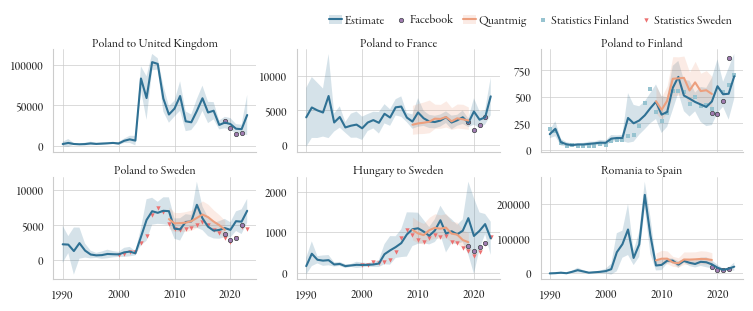

In [1711]:
# Plot an example pane
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("POL", "GBR"), ("POL", "FRA"), ("POL", "FIN"), ("POL", "SWE"), ("HUN", "SWE"), ("ROU", "ESP")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)
fig.savefig("Images/Europe_flows.pdf")

## West Africa, 2016

In [71]:
color_dict=dict(POL='#FFF4CA',
                UKR=colors['c_orange'],
                RUS=colors['c_lightblue'],
                ROU=colors['c_yellow'],
                KAZ=colors['c_lightgreen'],
                HUN=colors['c_pink'],
                NGA='#9FFFCB',
                NER=colors['c_red'],
                MLI=colors['c_orange'],
                CIV=colors['c_purple'],
                TCD=colors['c_lightblue'],
                GHA=colors['c_pink'],
                BEN='#598392',
                YEM='white',
                SSD=colors['c_lightgreen'],
                SDN=colors['c_yellow'],
                CAF='#A8DADC',
                CMR='#DECDF5',
                BFA='#E5E5E5'
                )

100%|██████████| 242/242 [00:04<00:00, 56.39it/s]


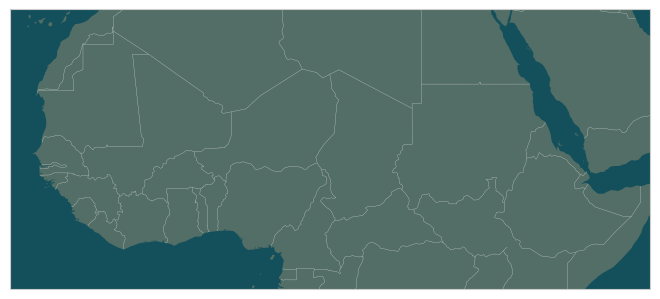

In [66]:
fig_4, ax_4 = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()))
add_borders(ax_4, edgecolor='white')
add_ocean(ax_4, color='#13505B', alpha=1)
ax_4.set(facecolor='#536E66', alpha=1)
patches_4 = putils.add_country_patches(world, ax_4, facecolor='#536E66', alpha=1)
ax_4.set_extent([-20, 50,0, 25])

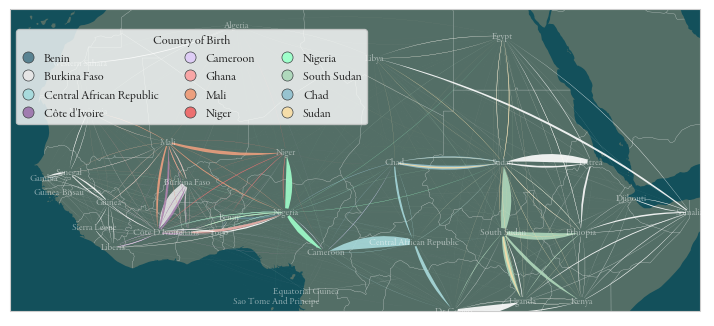

In [72]:
while(len(ax_4.patches)>0):
    ax_4.patches[-1].remove()
while(len(fig_4.artists)>0):
    fig_4.artists[-1].remove()

handles, labels = [], []
#list(zip(np.concat([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa']]), np.random.rand(len(np.concat([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa']]))))):
for birth_iso, rad in list(zip(np.concat([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa']]), np.random.rand(len(np.concat([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa']]))))):

    plot_flows(fig_4,
               flow_items=get_flow_items(predictions['T_pred']['mean'].sel({"Year": 2015, "Birth ISO": birth_iso, "Origin ISO": np.concat([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa']]), "Destination ISO": np.concat([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa']])}))[:200],
               scale=9e-4,
               #mutation_scale=10,
               shrinkA=3, shrinkB=3,
               #color_dict=color_dict,
               #color_key='Birth ISO',
               color=color_dict.get(birth_iso, 'white'),
               alpha=0.9,
               jiggle=0.0,
               connectionstyle=f'arc3, rad=0.1',
               arrowstyle='wedge,tail_width=0.1,shrink_factor=1.9',
               lw=0.,
               special_coords=dict(RUS=(56, 38), KAZ=(48, 52))
    )
    if birth_iso in color_dict.keys():
        handles.append(
            Line2D([0], [0], marker='o', lw=0, markeredgewidth=0.5, c=colors['c_darkgrey'], markerfacecolor=color_dict.get(birth_iso, colors['c_darkblue']), markersize=8, label=putils.iso_to_name(birth_iso))
        )
        labels.append(putils.iso_to_name(birth_iso))

highlight_countries(ax_4, patches_4, np.concat([countries_by_region['Sub-Saharan Africa'], countries_by_region['Northern Africa']]),
                    patch_kwargs=dict(facecolor='#536E66', ec=None, lw=0, zorder=None), text_kwargs=dict(color='white', fontsize=7), coordinates=coordinates)

# Get current bounding box of the figure in inches
bbox = fig_4.get_tightbbox(fig_4.canvas.get_renderer())
aspect = bbox.height / bbox.width
fig_4.patch.set_alpha(0)

# Add legend to plot
while len(fig_4.legends) > 0:
    fig_4.legends[-1].remove()
fig_4.legend(handles=handles, labels=labels, title='Country of Birth', loc='upper left', bbox_to_anchor=(0., 0.95), ncols=3, framealpha=0.8)

# Set size with fixed width and computed height
fig_4.set_size_inches(page_width, page_width * aspect)
fig_4

In [73]:
fig_4.savefig("Images/W_Africa_flows.pdf", pad_inches=0, bbox_inches='tight', transparent=False)

In [1762]:
# Get current bounding box of the figure in inches
bbox = fig_4.get_tightbbox(fig_4.canvas.get_renderer())
aspect = bbox.height / bbox.width

# Set size with fixed width and computed height
fig_4.set_size_inches(page_width, page_width * aspect)
fig_4.savefig("Images/W_Africa_flows.pdf", pad_inches=0, bbox_inches='tight')

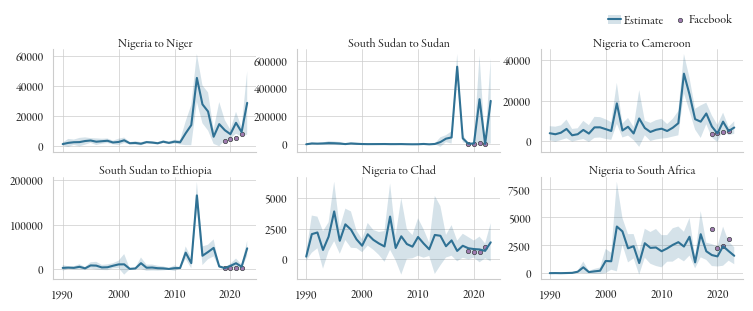

In [1730]:
# Plot an example pane
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("NGA", "NER"), ("SSD", "SDN"), ("NGA", "CMR"), ("SSD", "ETH"), ("NGA", "TCD"), ("NGA", "ZAF")]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)
# fig.savefig("Images/W_Africa_flows.pdf")

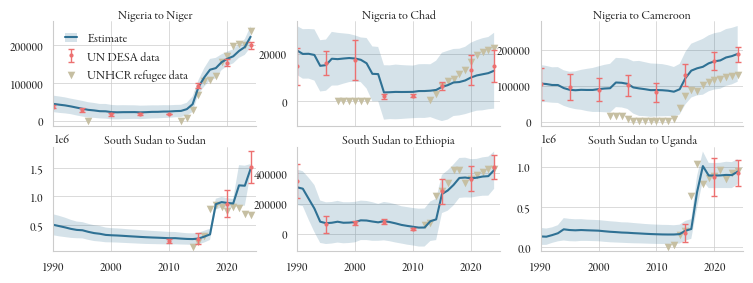

In [48]:
# Comparison of stocks
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/3), sharex=True)

for idx, (o, d) in enumerate([("NGA", "NER"), ("NGA", "TCD"), ("NGA", "CMR"), ("SSD", "SDN"), ("SSD", "ETH"), ("SSD", "UGA")]):
    _h1 = putils.errorband(predictions['S_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    _h2 = putils.errorbar(stock_data.sel({"Origin ISO": o, "Destination ISO": d}, drop=True), axs.flatten()[idx], y='2025 Revision', yerr='Error', lw=0, elinewidth=1, capsize=2, markersize=2, marker='o', zorder=2)
    axs.flatten()[idx].set(xlabel=None, ylabel=None)

    # Plot the stock of refugees
    _h3 = refugees.sel({"Origin ISO": o, "Destination ISO": d}, drop=True).where(lambda x: x>0).plot.scatter(
        ax=axs.flatten()[idx], label='UNHCR refugee data', s=30, lw=0, c=colors['c_lightbrown'], marker='v')
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', y=0.95)
    axs.flatten()[idx].set(ylabel=None, xlabel=None, xlim=(1990, 2025))

axs[0, 0].legend(handles=[_h1, _h2, _h3], labels=['Estimate', 'UN DESA data', 'UNHCR refugee data'])
fig.savefig("Images/W_Africa_stocks.pdf")

## Middle East

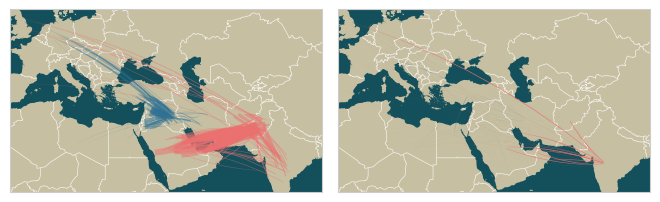

In [1577]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.05)
axs = np.array([
    fig.add_subplot(121, projection=ccrs.Mercator()),
    fig.add_subplot(122, projection=ccrs.Mercator())
    ])
for ax in axs:
    ax.set_extent([-5, 90, 12, 45])
    add_ocean(ax, color='#13505B', alpha=1)
    ax.set(facecolor=colors['c_lightbrown'], alpha=1)
    add_borders(ax, edgecolor='white', linewidth=0.5)

for country, color in [("PAK", colors['c_red']), ("IRQ", colors['c_darkblue'])]:

    plot_flows(fig, ax_idx=0,
               flow_items=get_flow_items(predictions['T_pred']['mean'].sel({"Year": range(2010, 2020), "Birth ISO": country}))[:100],
               #mutation_scale=10,
               scale=5e-4,
               shrinkA=0, shrinkB=0,
               color=color,
               #color_dict=color_dict,
               #color_key='Birth ISO',
               alpha=0.5,
               connectionstyle=f'arc3, rad=0.1',
               arrowstyle='wedge,tail_width=0.05,shrink_factor=1',
               lw=0.,
               jiggle=0.1,
               special_coords=dict(RUS=(56, 38), KAZ=(48, 52))
    )

    plot_flows(fig, ax_idx=1,
           flow_items=get_flow_items(predictions['T_pred']['mean'].sel({"Year": 2016, "Birth ISO": country}).drop_sel({"Origin ISO": country}).drop_sel({"Destination ISO": country}))[:500],
           #mutation_scale=1,
           scale=5e-4,
           shrinkA=3, shrinkB=3,
           color=color,
           #color_dict=color_dict,
           #color_key='Birth ISO',
           alpha=0.9,
           connectionstyle=f'arc3, rad=0.1',
           arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
           lw=0.,
           special_coords=dict(RUS=(56, 38), KAZ=(48, 52))
    )

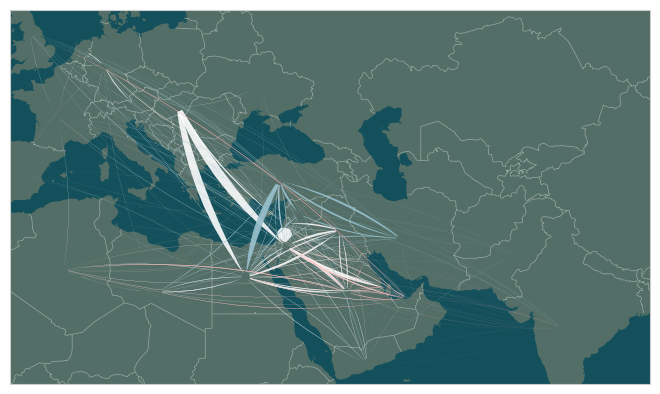

In [1494]:
fig_5, ax_5 = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()))
add_borders(ax_5)
add_ocean(ax_5, color='#13505B', alpha=1)
ax_5.set(facecolor='#536E66', alpha=1)
add_borders(ax_5, edgecolor=colors['c_lightgrey'], linewidth=0.5)
#patches_4 = putils.add_country_patches(world, ax_4, facecolor='#536E66', alpha=1)
ax_5.set_extent([-5, 90, 12, 45])

plot_flows(fig_5,
           get_flow_items(predictions['T_pred']['mean'].sel({"Year": 2016, "Birth ISO": "SYR"}).drop_sel({"Origin ISO": "SYR"}).drop_sel({"Destination ISO":"SYR"}))[:200],
           scale=10e-3,
           shrinkA=3, shrinkB=3,
           color='white',
           #color_dict=color_dict,
           #color_key='Birth ISO',
           alpha=0.9,
           connectionstyle=f'arc3, rad=0.1',
           arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
           lw=0.,
           special_coords=dict(RUS=(56, 38), KAZ=(48, 52))
)

plot_flows(fig_5,
           get_flow_items(predictions['T_pred']['mean'].sel({"Year": 2016, "Birth ISO": "IRQ"}).drop_sel({"Origin ISO": "IRQ"}).drop_sel({"Destination ISO":"IRQ"}))[:200],
           scale=10e-3,
           shrinkA=3, shrinkB=3,
           color=colors['c_lightblue'],
           #color_dict=color_dict,
           #color_key='Birth ISO',
           alpha=0.9,
           connectionstyle=f'arc3, rad=0.1',
           arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
           lw=0.,
           special_coords=dict(RUS=(56, 38), KAZ=(48, 52))
)

plot_flows(fig_5,
           get_flow_items(predictions['T_pred']['mean'].sel({"Year": 2016, "Birth ISO": "YEM"}).drop_sel({"Origin ISO": "YEM"}).drop_sel({"Destination ISO":"YEM"}))[:200],
           scale=10e-3,
           shrinkA=3, shrinkB=3,
           color=colors['c_pink'],
           #color_dict=color_dict,
           #color_key='Birth ISO',
           alpha=0.9,
           connectionstyle=f'arc3, rad=0.1',
           arrowstyle='wedge,tail_width=0.05,shrink_factor=2',
           lw=0.,
           special_coords=dict(RUS=(56, 38), KAZ=(48, 52))
)

In [427]:
import pandas as pd
from pyproj import Transformer

coordinates = pd.read_csv("Data/Coordinates.csv")[['Alpha-3 code', 'Latitude', 'Longitude']].set_index('Alpha-3 code').to_dict()
coordinates['Latitude']['RUS'] = 55.7558
coordinates['Longitude']['RUS'] = 37.6173

coordinates['Latitude']['KAZ'] = 48
coordinates['Longitude']['KAZ'] = 52
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
coordinates = dict((k, transformer.transform(coordinates['Latitude'][k], coordinates['Longitude'][k])) for k in coordinates['Latitude'].keys())

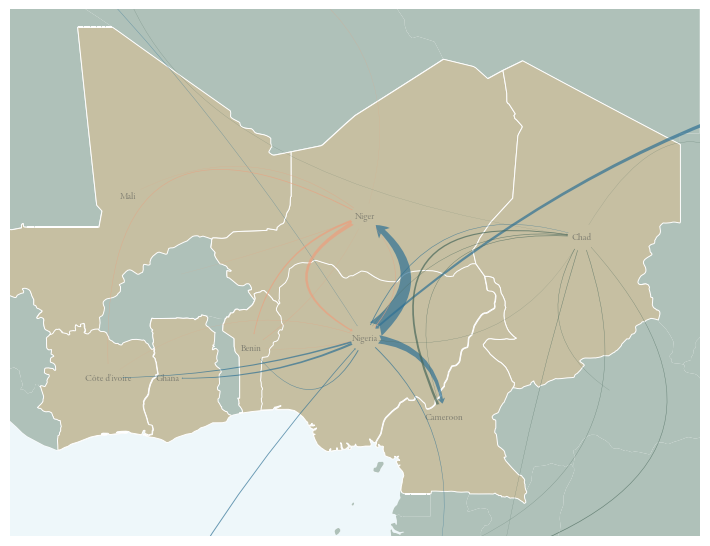

In [460]:
for patch in ax_1.patches:
    patch.remove()

plot_flows_to_map(ax_1,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "NGA", "Destination ISO": countries_by_region['Sub-Saharan Africa'], "Year": 2016})
                  ), mutation_scale=1e-3, n_items=10, color=colors['c_darkblue'])

plot_flows_to_map(ax_1,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "NER", "Destination ISO": countries_by_region['Sub-Saharan Africa'], "Year": 2016})
                  ), mutation_scale=1e-3, n_items=10, color=colors['c_orange'])

plot_flows_to_map(ax_1,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "TCD", "Destination ISO": countries_by_region['Sub-Saharan Africa'], "Year": 2016})
                  ), mutation_scale=1e-3, n_items=10, color=colors['c_darkgreen'])


highlight_countries(ax_1, patches_1, ['NGA', 'NER', 'CMR', 'TCD', 'MLI', 'BEN', 'GHA', 'CIV'])

fig_1

100%|██████████| 242/242 [00:02<00:00, 97.68it/s] 


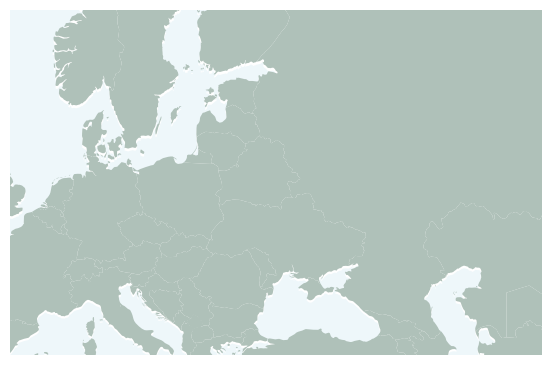

In [484]:
fig_2, ax_2 = plt.subplots(subplot_kw=dict(projection=ccrs.Mercator()), figsize=(page_width, page_width/2))
putils.add_map(ax_2)
patches_2 = putils.add_country_patches(ax_2)
ax_2.set_extent([0, 60, 40, 60])

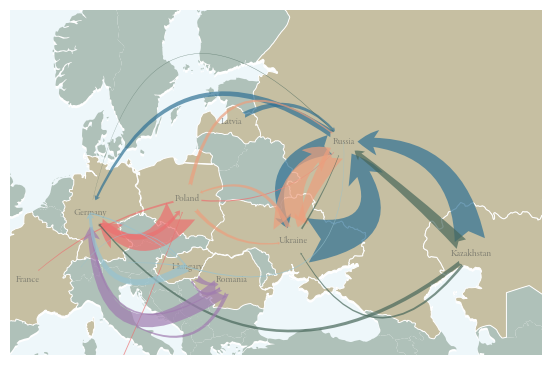

In [473]:
ax_2.set_extent([0, 60, 40, 60])
for patch in ax_2.patches:
    patch.remove()

plot_flows_to_map(ax_2,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "RUS", "Destination ISO": countries_by_region['Europe'], "Year": 1991})
                  ), mutation_scale=5e-4, n_items=5, color=colors['c_darkblue'])

plot_flows_to_map(ax_2,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "POL", "Destination ISO": countries_by_region['Europe'], "Year": 1991})
                  ), mutation_scale=5e-4, n_items=5, color=colors['c_red'])

plot_flows_to_map(ax_2,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "UKR", "Destination ISO": countries_by_region['Europe'], "Year": 1991})
                  ), mutation_scale=5e-4, n_items=5, color=colors['c_orange'])

plot_flows_to_map(ax_2,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "KAZ", "Destination ISO": countries_by_region['Europe'], "Year": 1991})
                  ), mutation_scale=5e-4, n_items=5, color=colors['c_darkgreen'])

plot_flows_to_map(ax_2,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "ROU", "Destination ISO": countries_by_region['Europe'], "Year": 1991})
                  ), mutation_scale=5e-4, n_items=5, color=colors['c_purple'])

plot_flows_to_map(ax_2,
                  get_flow_items(
                    predictions['T_pred']['mean'].sel({"Birth ISO": "HUN", "Destination ISO": countries_by_region['Europe'], "Year": 1991})
                  ), mutation_scale=5e-4, n_items=5, color=colors['c_lightblue'], shrinkB=0, shrinkA=0)

highlight_countries(ax_2, patches_2, ['RUS', 'KAZ', 'UKR', 'POL', 'DEU', 'FRA', 'LVA', 'HUN', 'ROU'])

fig_2

In [146]:
t_flows = get_flow_items(predictions['T_pred']['mean'])
t_flows = sorted(t_flows, reverse=True, key=lambda x: x['Value'])

In [12]:
import cartopy.mpl.geoaxes as cgeo

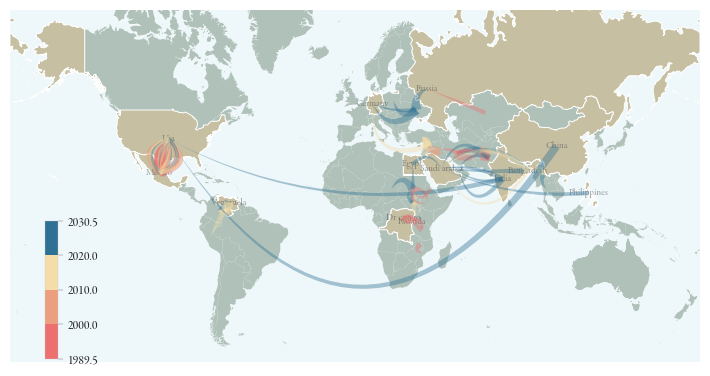

In [21]:

highlight_countries(ax_3, patches_3, ['RUS', 'USA', 'SAU','DEU', 'IND', 'BGD', 'MEX', 'VEN', 'CHN', 'PHL', 'RWA', 'EGY', 'COD'])


cm = ColorManager(cmap={'from_values': {1995: colors['c_red'], 2005: colors['c_orange'], 2015: colors['c_yellow'], 2025: colors['c_darkblue']}})

# , vmin=1990, vmax=2023, norm=dict(name='BoundaryNorm', boundaries=[1990, 2000, 2010, 2020, 2024], ncolors=256)
color_dict = dict((y, colors['c_darkblue']) for y in predictions['T_pred'].coords['Year'].data)
for y in color_dict.keys():
    color_dict[y] = cm.map_to_color(y)

for patch in ax_3.patches:
    patch.remove()
to_remove = []
for ax in fig_3._localaxes:
    if not isinstance(ax, cgeo.GeoAxes):
        to_remove.append(ax)
for ax in to_remove:
    ax.remove()
plot_flows_to_map(ax_3, t_flows[:100], mutation_scale=5e-6, alpha=0.4, n_items=1000, shrinkA=0, shrinkB=0, color=colors['c_darkblue'], arrowstyle=f'wedge,tail_width=2', color_dict=color_dict, color_key='Year')
putils.add_cbar_to_map(fig_3, cm, cbar_loc=[0.05, 0.25, 0.02, 0.2])
fig_3

In [ ]:
proj1 = ccrs.Orthographic(central_longitude=60, central_latitude=20)
ax1 = fig.add_subplot(121, projection=proj1)

# # Orthographic projection centered on Asia (e.g., lat=30, lon=100)
world.to_crs('+proj=ortho +lat_0=20 +lon_0=60 +x_0=0 +y_0=0 +a=6371000 +b=6371000 +units=m +no_defs').plot(ax=ax1, color=colors['c_lightbrown'], alpha=0.6)

    for country in tqdm.tqdm(list(world['ISO_A3_EH'])):
        p = world[world['ISO_A3_EH'] == country].plot(color=land_color, ax=ax, zorder=0, lw=0.)
        country_patches[country] = p._children[-1]
    return country_patches

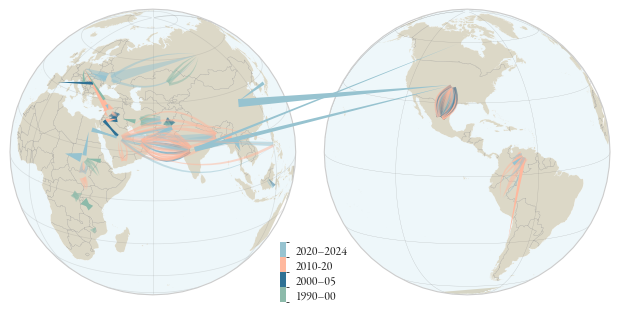

In [527]:
def get_figure_coords(x, y, fig, ax1, ax2):

    x1, y1 = ax1.projection.transform_point(x, y, ccrs.Geodetic())
    if not(np.isnan(x1) or np.isnan(y1)):
            fig_coords = fig.transFigure.inverted().transform(
                ax1.transData.transform((x1, y1))
            )
            which = '1'
    else:
        x1, y1 = ax2.projection.transform_point(x, y, ccrs.Geodetic())
        fig_coords = fig.transFigure.inverted().transform(
            ax2.transData.transform((x1, y1))
        )
        which = '2'
    return x1, y1, which, *fig_coords

def plot_connection(ax_src, ax_dest, coord1, coord2, **kwargs):

    # 1. Convert to Orthographic coordinates
    x1, y1, which_1, *src_figcoords = get_figure_coords(*coord1, fig, ax_src, ax_dest)
    x2, y2, which_2, *dest_figcoords = get_figure_coords(*coord2, fig, ax_src, ax_dest)

    # Skip if points are not visible
    if not all(np.isfinite([x1, y1, x2, y2])):
        print('na')
        return

    # 5. Draw line in figure coordinates
    patch = FancyArrowPatch(
        posA=src_figcoords, posB=dest_figcoords,
        transform=fig.transFigure,
        **kwargs,
    )
    fig.add_artist(patch)

for c in ax1.collections[3:]:
    c.remove()
for c in ax2.collections[3:]:
    c.remove()
while len(fig.artists) > 0:
    fig.artists[-1].remove()
for l in ax1.lines:
    l.remove()
for l in ax2.lines:
    l.remove()
for l in fig.lines:
    l.remove()

cm = ColorManager(cmap={'from_values': {1995: '#8CBAAA', 2005: colors['c_darkblue'], 2015: '#FFB89E', 2025: colors['c_lightblue']}})

items = {}
for item in t_flows[:200]:
    if (item['Origin ISO'], item['Destination ISO']) not in items.keys():
        items[(item['Origin ISO'], item['Destination ISO'])] = [(item['Year'], item['Value'])]
    else:
        items[(item['Origin ISO'], item['Destination ISO'])].append((item['Year'], item['Value']))

for k, v in items.items():
    for idx, flow in enumerate(v):
        rad = (-1)**idx * float(idx) / len(v) * 0.6
        alpha = max(0.5, 1/len(v))
        plot_connection(ax1, ax2, coordinates[k[0]][::-1], coordinates[k[1]][::-1], mutation_scale=5e-6*flow[1],
                    color=cm.map_to_color(flow[0]), arrowstyle=f'wedge,tail_width=2', connectionstyle=f'arc3,rad={rad}', alpha=alpha, lw=0)

for ax in fig.axes[2:]:
    ax.remove()
cbar_loc = [0.45, 0.25, 0.01, 0.1]
cax = fig.add_axes(cbar_loc)
from matplotlib.colorbar import Colorbar
cbar = Colorbar(
        cax, cmap=cm.cmap, orientation='vertical', location='right', drawedges=False, norm=cm.norm
    )
cbar.set_ticks([1995, 2005, 2015, 2025], labels=['1990–00', '2000–05', '2010-20', '2020–2024'])
cbar.outline.set_linewidth(0.2)
cbar.dividers.set_color('none')
cbar.outline.set_visible(False)  # Remove colorbar border
cax.tick_params(width=0.)
cbar.dividers.set_color('none')
#fig.savefig("Images/global_flows.png", dpi=400, transparent=True, bbox_inches='tight')
fig

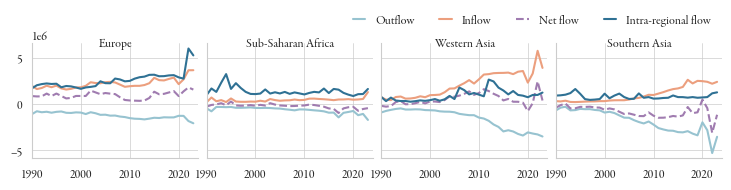

In [419]:
fig, axs = plt.subplots(ncols=4, nrows=1, sharex=True, sharey=True, figsize=(page_width, page_width/6), gridspec_kw={'wspace': 0.05})

for idx, region in enumerate(['Europe', 'Sub-Saharan Africa', 'Western Asia', 'Southern Asia']):
    out_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": np.concat([countries_by_region[k] for k in countries_by_region.keys() if k != region])}).sum(['Origin ISO', 'Destination ISO'])
    in_flow = predictions['F_pred']['mean'].sel({"Destination ISO": countries_by_region[region], "Origin ISO": np.concat([countries_by_region[k] for k in countries_by_region.keys() if k != region])}).sum(['Origin ISO', 'Destination ISO'])
    (-1*out_flow).plot(ax=axs.flatten()[idx], label='Outflow' if idx == 0 else None, c=colors['c_lightblue'])
    in_flow.plot(ax=axs.flatten()[idx], label='Inflow' if idx == 0 else None, c=colors['c_orange'])
    (in_flow - out_flow).plot(ax=axs.flatten()[idx], label='Net flow' if idx == 0 else None, c=colors['c_purple'], ls='dashed')

    intra_flow = predictions['F_pred']['mean'].sel({"Origin ISO": countries_by_region[region], "Destination ISO": countries_by_region[region]}).sum(['Origin ISO', 'Destination ISO'])
    intra_flow.plot(ax=axs.flatten()[idx], label='Intra-regional flow' if idx == 0 else None,)

    axs.flatten()[idx].set_title(region, x=.50, y=0.9, ha='center')
    axs.flatten()[idx].set(xlabel=None, ylabel=None, xlim=(1990, 2024))


# predictions['F_pred']['mean'].sum(["Origin ISO", "Destination ISO"]).plot(ax=axs.flatten()[-1])
# axs.flatten()[-1].set(xlabel=None, ylabel=None)
fig.legend(bbox_to_anchor=(1, 1.05), loc='lower right', ncols=4)

#fig.savefig("Images/regional_flows.pdf", bbox_inches='tight', transparent=True)

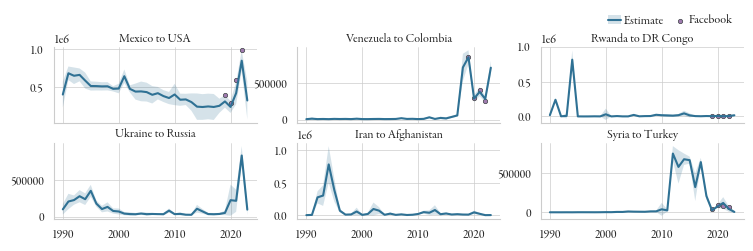

In [965]:
# Plot an example pane
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(page_width, page_width/4), sharex=True, gridspec_kw={'hspace': 0.25})

handles = {}
for idx, (o, d) in enumerate([("MEX", "USA"), ("VEN", "COL"), ("RWA", "COD"), ('UKR', 'RUS'), ('IRN', 'AFG'), ('SYR', 'TUR')]):
    _h1 = putils.errorband(predictions['F_pred'].sel({"Origin ISO": o, "Destination ISO": d}), axs.flatten()[idx])
    handles['Estimate'] = _h1
    handles.update(**putils.plot_flow_data(axs.flatten()[idx], flow_dsets, o=o, d=d))
    axs.flatten()[idx].set_title(f'{putils.iso_to_name(o)} to {putils.iso_to_name(d)}', x=0.5, ha='center', y=0.95)

fig.legend(handles=list(handles.values()), labels=list(handles.keys()), bbox_to_anchor=(1, 1.05), loc='lower right', columnspacing=0.8, ncols=6, handletextpad=0.2)

fig.savefig("Images/shocks_1.pdf", bbox_inches='tight', transparent=True)